# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


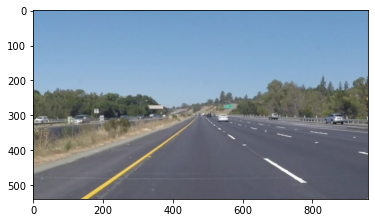

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidYellowLeft.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #left_pts =[]
    #right_pts = []
    right_si = []
    left_si = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_lines2(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #left_pts =[]
    #right_pts = []
    right_si = []
    left_si = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y1-slope*x1
            if slope > 0:
                #left_pts.append([x1,y1])
                #left_pts.append([x2,y2])
                left_si.append([slope,intercept])
                
            elif slope < 0:
                #right_pts.append([x1,y1])
                #right_pts.append([x2,y2])
                right_si.append([slope,intercept])
                
                   
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    left_slope,left_intercept = find_si(left_si, side = "left")
    #left_si =np.asarray(left_si)
    #left_slope = np.median(left_si[:,0])
    #left_intercept = np.median(left_si[:,1])
    print(left_slope, left_intercept)
    
    right_slope,right_intercept = find_si(right_si, side = "right")
    #right_si =np.asarray(right_si)
    #right_slope = np.median(right_si[:,0])
    #right_intercept = np.median(right_si[:,1])
    print(right_slope,right_intercept)
    p1l = (np.int(((img.shape[0]-1)-left_intercept)/left_slope),np.int(img.shape[0]-1))
    p2l = (np.int(((320)-left_intercept)/left_slope),np.int(320))
    p1r = (np.int(((img.shape[0]-1)-right_intercept)/right_slope),np.int(img.shape[0]-1))
    p2r = (np.int(((320)-right_intercept)/right_slope),np.int(320))
    #print(right_slope,right_intercept)
    #p1r,p2r = find_points(right_pts, right_slope,right_intercept,img.shape,p1r,p2r)
    #print(p1r,p2r)
    #p1l,p2l = find_points(left_pts, left_slope,left_intercept,img.shape,p1l,p2l)
    #print(p1l,p2l)
    cv2.line(img, p1r, p2r, color, thickness)
    cv2.line(img, p1l, p2l, color, thickness)
    
def draw_lines_challenge(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #left_pts =[]
    #right_pts = []
    right_si = []
    left_si = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y1-slope*x1
            if slope > 0:
                #left_pts.append([x1,y1])
                #left_pts.append([x2,y2])
                left_si.append([slope,intercept])
                
            elif slope < 0:
                #right_pts.append([x1,y1])
                #right_pts.append([x2,y2])
                right_si.append([slope,intercept])
                
                   
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    left_slope,left_intercept = find_si(left_si,side = "left")
    #left_si =np.asarray(left_si)
    #left_slope = np.median(left_si[:,0])
    #left_intercept = np.median(left_si[:,1])
    print(left_slope, left_intercept)
    
    right_slope,right_intercept = find_si(right_si,side = "right")
    #right_si =np.asarray(right_si)
    #right_slope = np.median(right_si[:,0])
    #right_intercept = np.median(right_si[:,1])
    print(right_slope,right_intercept)
    p1l = (np.int(((img.shape[0]-1)-left_intercept)/left_slope),np.int(img.shape[0]-1))
    p2l = (np.int(((450)-left_intercept)/left_slope),np.int(450))
    p1r = (np.int(((img.shape[0]-1)-right_intercept)/right_slope),np.int(img.shape[0]-1))
    p2r = (np.int(((450)-right_intercept)/right_slope),np.int(450))
    #print(right_slope,right_intercept)
    #p1r,p2r = find_points(right_pts, right_slope,right_intercept,img.shape,p1r,p2r)
    #print(p1r,p2r)
    #p1l,p2l = find_points(left_pts, left_slope,left_intercept,img.shape,p1l,p2l)
    #print(p1l,p2l)
    cv2.line(img, p1r, p2r, color, thickness)
    cv2.line(img, p1l, p2l, color, thickness)
   
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img,lines)
    return line_img

def hough_lines2(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines2(line_img,lines)
    return line_img

def hough_lines_challenge(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_challenge(line_img,lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [4]:
def find_si(slope_intercept, side = "left"):
    global prev_slope_left
    global prev_intercept_left
    global prev_slope_right
    global prev_intercept_right
    
    
    keep_slopes = []
    keep_intercepts = []
     
    #print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    intercepts = [pair[1] for pair in slope_intercept]
    for pair in slope_intercept:
        slope = pair[0]
        intercept = pair[1]
        if slope - np.mean(slopes) < 1.5 * np.std(slopes):
            keep_slopes.append(slope)
        if intercept - np.mean(intercepts) < 1.5* np.std(intercepts):
            keep_intercepts.append(intercept)
    
    
                        
    
    # Take estimate of slope, intercept to be the mean of remaining values
    if side == "left":
        
        slope = np.median(keep_slopes)
        if math.isnan(slope):
            slope = prev_slope_left
        #elif prev_slope_left!= 0 and abs((slope - prev_slope_left)/prev_slope_left)>0.025:
            #slope = prev_slope_left
        
            
        intercept = np.median(keep_intercepts)
        if math.isnan(intercept):
            intercept = prev_intercept_left
        #elif prev_intercept_left!= 0 and abs((intercept - prev_intercept_left)/prev_intercept_left)>0.025:
            #intercept = prev_intercept_left
            
            
        prev_slope_left = slope
        prev_intercept_left = intercept
    
    elif side == "right":
        slope = np.median(keep_slopes)
        if math.isnan(slope):
            slope = prev_slope_right
        #elif prev_slope_right!= 0 and abs((slope - prev_slope_right)/prev_slope_right)>0.025:
            #slope = prev_slope_right
            
        intercept = np.median(keep_intercepts)
        if math.isnan(intercept):
            intercept = prev_intercept_right
        #elif prev_intercept_right!= 0 and abs((intercept - prev_intercept_right)/prev_intercept_right)>0.025:
            #intercept = prev_intercept_right
            
            
        prev_slope_right = slope
        prev_intercept_right = intercept
    
    #print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept

def find_points(points, slope,intercept, imgshape):
    
    y = []
    for pair in points:
        y.append(pair[1])
        
    y1 = np.int(np.amin(y))
    y1_cond = math.isnan(y1)
    y2 = imgshape[0]-1
    x1 =np.int((y1-intercept)/slope)
    x2 = np.int((y2-intercept)/slope)
    p1 = (x1,y1)
    p2 = (x2,y2)
    return p1,p2
    

In [5]:
prev_slope_left = 0
prev_intercept_left = 0
prev_slope_right = 0
prev_intercept_right= 0

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [25]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
def pipeline(image):
    
    
    img = np.copy(image)
    img1 = img[:,:,1]
    imgshape=img.shape
    #plt.subplot(2,3,1)
    #plt.imshow(img1, cmap = 'Reds')
    
    #convert image to grayscale
    gray = grayscale(img)
    #plt.subplot(2,3,2)
    plt.imshow(gray, cmap ='gray')
    plt.savefig('test_image_output/gray.png', dpi=300, bbox_inches='tight')
    
    #Gaussian Blur to smoothen the image
    kernel_size = 5
    blurred = gaussian_blur(gray, kernel_size)
   #plt.subplot(2,3,3)
    plt.imshow(blurred,cmap ='gray')
    plt.savefig('test_image_output/blurred.png', dpi=300, bbox_inches='tight')
    
    #use canny edge detection to identify strong gradients and convert to binary image
    high_threshold = 150
    low_threshold = 50
    edges = canny(blurred, low_threshold, high_threshold)
    #plt.subplot(2,3,4)
    plt.imshow(edges,cmap = 'gray')
    plt.savefig('test_image_output/edges.png', dpi=300, bbox_inches='tight')
    
    #create Mask to identify region of interest
    vertices = np.array([[(0,imgshape[0]),(450,320),(550,320),(imgshape[1],imgshape[0])]],dtype = np.int32)
    masked = region_of_interest(edges, vertices)
    #plt.subplot(2,3,5)
    plt.imshow(masked, cmap = 'gray')
    plt.savefig('test_image_output/RoI.png', dpi=300, bbox_inches='tight')
    
    #Perform Hough transform to identify lanes in region of interest
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 40
    max_line_gap = 20
    lines = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap)
    print("lines", lines.shape)
    plt.imshow(lines, cmap = 'gray')
    plt.savefig('test_image_output/lanelines.png', dpi=300, bbox_inches='tight')
    
    #combine lane lines with original image
    output = weighted_img(lines,img)
    
    
    #plot and return
    #plt.subplot(2,3,6)
    plt.imshow(output)
    plt.savefig('test_image_output/output.png', dpi=300, bbox_inches='tight')
    return output
    
    

lines (540, 960, 3)


array([[[147, 157, 168],
        [115, 127, 142],
        [106, 123, 142],
        ...,
        [102, 122, 141],
        [112, 129, 142],
        [146, 159, 171]],

       [[114, 126, 142],
        [115, 130, 147],
        [106, 125, 146],
        ...,
        [ 99, 123, 144],
        [110, 127, 144],
        [113, 128, 142]],

       [[105, 122, 141],
        [106, 125, 146],
        [100, 123, 147],
        ...,
        [ 94, 120, 145],
        [ 98, 120, 142],
        [100, 121, 139]],

       ...,

       [[103, 102, 107],
        [ 92,  91,  96],
        [ 88,  87,  92],
        ...,
        [ 66,  66,  74],
        [ 70,  70,  78],
        [ 95,  95, 103]],

       [[113, 112, 116],
        [100,  99, 103],
        [ 92,  91,  95],
        ...,
        [ 70,  70,  78],
        [ 85,  85,  91],
        [109, 109, 115]],

       [[141, 140, 144],
        [111, 110, 114],
        [102, 102, 106],
        ...,
        [ 95,  95, 102],
        [110, 110, 116],
        [146, 146, 153]]

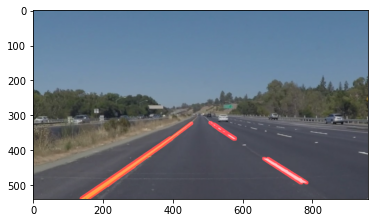

In [26]:
pipeline(image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
prev_slope_left =0
prev_intercept_left = 0
prev_slope_right =0
prev_intercept_right = 0
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = pipeline(image)
    

    return result

Let's try the one with the solid white lane on the right first ...

t:   1%|▉                                                                    | 3/221 [00:00<00:07, 27.85it/s, now=None]

lines (540, 960, 3)
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines

t:   6%|████▎                                                               | 14/221 [00:00<00:05, 35.38it/s, now=None]

 (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines

t:   9%|█████▊                                                              | 19/221 [00:00<00:05, 37.93it/s, now=None]

 (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


t:  13%|████████▉                                                           | 29/221 [00:00<00:04, 41.83it/s, now=None]

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines

t:  18%|████████████                                                        | 39/221 [00:00<00:04, 44.58it/s, now=None]

 (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


t:  22%|███████████████                                                     | 49/221 [00:01<00:03, 43.93it/s, now=None]

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


t:  27%|██████████████████▏                                                 | 59/221 [00:01<00:03, 44.78it/s, now=None]

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines

t:  31%|█████████████████████▏                                              | 69/221 [00:01<00:03, 44.96it/s, now=None]

 (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines

t:  33%|██████████████████████▊                                             | 74/221 [00:01<00:03, 46.14it/s, now=None]

 (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


t:  38%|█████████████████████████▊                                          | 84/221 [00:01<00:02, 46.59it/s, now=None]

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


t:  43%|████████████████████████████▉                                       | 94/221 [00:02<00:02, 46.87it/s, now=None]

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


t:  47%|███████████████████████████████▌                                   | 104/221 [00:02<00:02, 46.30it/s, now=None]

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines

t:  49%|█████████████████████████████████                                  | 109/221 [00:02<00:02, 41.92it/s, now=None]

 (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


t:  55%|████████████████████████████████████▋                              | 121/221 [00:02<00:02, 45.84it/s, now=None]

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


t:  59%|███████████████████████████████████████▋                           | 131/221 [00:02<00:01, 46.80it/s, now=None]

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines

t:  64%|██████████████████████████████████████████▋                        | 141/221 [00:03<00:01, 46.78it/s, now=None]

 (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


t:  68%|█████████████████████████████████████████████▊                     | 151/221 [00:03<00:01, 46.22it/s, now=None]

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


t:  73%|████████████████████████████████████████████████▊                  | 161/221 [00:03<00:01, 46.02it/s, now=None]

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines

t:  77%|███████████████████████████████████████████████████▊               | 171/221 [00:03<00:01, 46.78it/s, now=None]

 (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


t:  82%|██████████████████████████████████████████████████████▊            | 181/221 [00:03<00:00, 46.80it/s, now=None]

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


t:  84%|████████████████████████████████████████████████████████▍          | 186/221 [00:04<00:00, 46.56it/s, now=None]

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


t:  89%|███████████████████████████████████████████████████████████▍       | 196/221 [00:04<00:00, 46.75it/s, now=None]

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


t:  93%|██████████████████████████████████████████████████████████████▍    | 206/221 [00:04<00:00, 46.41it/s, now=None]

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


t:  98%|█████████████████████████████████████████████████████████████████▍ | 216/221 [00:04<00:00, 45.61it/s, now=None]

lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)
lines (540, 960, 3)


lines (540, 960, 3)
Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 5.11 s


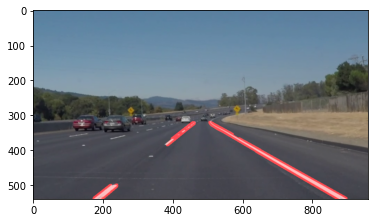

In [11]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
def pipeline2(image):
    
    
    img = np.copy(image)
    img1 = img[:,:,1]
    imgshape=img.shape
    #plt.subplot(2,3,1)
    #plt.imshow(img1, cmap = 'Reds')
    #convert image to grayscale
    gray = grayscale(img)
    #plt.subplot(2,3,2)
    plt.imshow(gray, cmap ='gray')
    
    #Gaussian Blur to smoothen the image
    kernel_size = 5
    blurred = gaussian_blur(gray, kernel_size)
    #plt.subplot(2,3,3)
    plt.imshow(blurred,cmap ='gray')
    #use canny edge detection to identify strong gradients and convert to binary image
    high_threshold = 150
    low_threshold = 50
    edges = canny(blurred, low_threshold, high_threshold)
    #plt.subplot(2,3,4)
    plt.imshow(edges)
    #create Mask to identify region of interest
    vertices = np.array([[(0,imgshape[0]),(450,320),(550,320),(imgshape[1],imgshape[0])]],dtype = np.int32)
    masked = region_of_interest(edges, vertices)
    #plt.subplot(2,3,5)
    plt.imshow(masked)
    #Perform Hough transform to identify lanes in region of interest
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 40
    max_line_gap = 20
    lines = hough_lines2(masked, rho, theta, threshold, min_line_len, max_line_gap)
    print("lines", lines.shape)
    #combine lane lines with original image
    output = weighted_img(lines,img)
    
    #plot and return
    #plt.subplot(2,3,6)
    plt.imshow(output)
    return output

In [14]:
prev_slope_left =0
prev_intercept_left = 0
prev_slope_right =0
prev_intercept_right = 0
def process_image2(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = pipeline2(image)
    

    return result

t:   0%|▎                                                                    | 3/681 [00:00<00:22, 29.78it/s, now=None]

0.6758116883116883 -31.172727272727315
-0.6108362196932211 600.1395348837209
lines (540, 960, 3)
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

0.6758116883116883 -31.172727272727315
-0.6108362196932211 600.1395348837209
lines (540, 960, 3)
0.6962962962962963 -31.088888888888903
-0.6190476190476191 606.7619047619048
lines (540, 960, 3)
0.6648809523809525 -20.5
-0.6125703564727956 602.8780487804878
lines (540, 960, 3)
0.6984848484848485 -37.07317073170731
-0.641295025728988 611.860671936759
lines (540, 960, 3)
0.6990595611285266 -36.494252873563255
-0.6257309941520468 611.1627004805744
lines (540, 960, 3)
0.7007462686567164

t:   2%|█▎                                                                  | 13/681 [00:00<00:18, 36.74it/s, now=None]

 -38.477611940298516
-0.6296598639455783 612.9466666666667
lines (540, 960, 3)
0.6488269794721407 -16.903225806451587
-0.6381818181818182 621.8450704225352
lines (540, 960, 3)
0.6723163841807909 -32.69816083663903
-0.6381818181818182 625.2790697674419
lines (540, 960, 3)
0.6561913696060038 -12.19230769230768
-0.64 626.0909090909091
lines (540, 960, 3)
0.6965102974828374 -38.4473684210526
-0.6566013071895425 625.6360606060606
lines (540, 960, 3)
0.6981132075471698 -39.57232704402517
-0.67144412191582 628.6792452830189
lines (540, 960, 3)
0.6447368421052632 -6.982894736842127
-0.6739310344827587 634.768
lines (540, 960, 3)
0.65 -13.297540983606552
-0.6355737704918033 616.28
lines (540, 960, 3)
0.646692745376956 -15.16216216216219
-0.6746987951807228 630.9879518072289
lines (540, 960, 3)
0.6815230961298377 -33.46153846153845
-0.6511627906976745 635.0232558139535


t:   3%|██▎                                                                 | 23/681 [00:00<00:16, 39.48it/s, now=None]

lines (540, 960, 3)
0.651685393258427 -14.314606741573073
-0.6754385964912281 631.5719988172679
lines (540, 960, 3)
0.6349206349206349 0.6507936507936734
-0.6926961681712013 637.9236790606653
lines (540, 960, 3)
0.6476190476190476 -9.782608695652186
-0.6874201787994891 634.3888888888889
lines (540, 960, 3)
0.6178728070175439 6.681469298245645
-0.6805717176827726 639.64
lines (540, 960, 3)
0.6461538461538462 -13.344147157190662
-0.7196969696969697 651.5833333333334
lines (540, 960, 3)
0.625 -7.767889492753625
-0.7222222222222222 641.6580882352941
lines (540, 960, 3)
0.6500465983224604 -12.551724137931046
-0.6742788461538461 624.0
lines (540, 960, 3)
0.6551724137931034 -24.246753246753258
-0.6934781346187351 639.5074626865671


t:   4%|██▊                                                                 | 28/681 [00:00<00:15, 41.13it/s, now=None]

lines (540, 960, 3)
0.631578947368421 -2.50177462289264
-0.6851851851851852 631.09375
lines (540, 960, 3)
0.631578947368421 -11.941176470588232
-0.6818181818181818 626.0
lines (540, 960, 3)
0.6327272727272728 -5.327272727272771
-0.6851851851851852 633.7037037037037
lines (540, 960, 3)
0.6095415778251598 16.25373134328356
-0.6955205811138014 642.2686567164179
lines (540, 960, 3)
0.6209677419354839 1.8155680224403739
-0.7353005704256252 655.8207547169811
lines (540, 960, 3)
0.5952380952380952 0.5637480798771151
-0.7111111111111111 641.8747967479674
lines (540, 960, 3)
0.6190476190476191 -1.8613861386138524
-0.7230769230769231 644.4854700854701
lines (540, 960, 3)
0.6481481481481481 -17.03703703703701
-0.7261410788381742 656.5657142857143
lines (540, 960, 3)
0.6551724137931034

t:   6%|███▊                                                                | 38/681 [00:00<00:14, 42.94it/s, now=None]

 -20.34482758620686
-0.6875 634.1875
lines (540, 960, 3)
0.6470588235294118 -15.589366515837128
-0.7243589743589743 649.0893104643105
lines (540, 960, 3)
0.6396103896103896 -13.0
-0.7278959810874704 642.1333333333333
lines (540, 960, 3)
0.625 -7.7329545454545325
-0.7536231884057971 664.2841530054645
lines (540, 960, 3)
0.6585365853658537 -23.65853658536588
-0.7540983606557377 664.092213114754
lines (540, 960, 3)
0.5918560606060606 8.645833333333371
-0.7692307692307693 667.7291666666667
lines (540, 960, 3)
0.6557377049180327 -22.076005961251838
-0.726775956284153 649.870238095238
lines (540, 960, 3)
0.6018518518518519 10.78867924528302
-0.7523584905660378 652.4233870967741
lines (540, 960, 3)
0.6071428571428571 4.60714285714289
-0.7062937062937062 639.7701863354038
lines (540, 960, 3)
0.6197991391678623

t:   7%|████▊                                                               | 48/681 [00:01<00:14, 44.02it/s, now=None]

 -3.65853658536588
-0.7473404255319149 649.8085106382979
lines (540, 960, 3)
0.625 -2.69123134328359
-0.745991332611051 650.9846153846154
lines (540, 960, 3)
0.5979381443298969 -0.4969114619080415
-0.7434177215189873 649.3
lines (540, 960, 3)
0.6318705673758864 -5.902260638297861
-0.751937984496124 656.3208440999139
lines (540, 960, 3)
0.6290322580645161 -8.404377880184313
-0.7295127353266888 658.6425802879291
lines (540, 960, 3)
0.6538461538461539 -18.62820512820511
-0.7419354838709677 647.4239631336405
lines (540, 960, 3)
0.6078431372549019 11.610644257703086
-0.7333333333333333 653.5641120117907
lines (540, 960, 3)
0.620253164556962 3.0
-0.7322075379344102 653.035340186001
lines (540, 960, 3)
0.6093431252549979 5.157894736842081
-0.7256578947368422 647.3617021276596
lines (540, 960, 3)
0.6232426303854876

t:   9%|█████▊                                                              | 58/681 [00:01<00:13, 44.83it/s, now=None]

 -9.466666666666697
-0.7391304347826086 654.9435215946844
lines (540, 960, 3)
0.5925925925925926 13.826271186440664
-0.74 647.7391304347826
lines (540, 960, 3)
0.6213207547169811 3.839999999999975
-0.7033795394661473 639.079757131401
lines (540, 960, 3)
0.6013698630136985 13.178082191780845
-0.7191607684529828 647.9130434782609
lines (540, 960, 3)
0.6189936215450036 0.7228915662650479
-0.7331118493909192 642.0
lines (540, 960, 3)
0.6104702750665484 10.086956521739125
-0.75 661.25
lines (540, 960, 3)
0.6222222222222222 1.2874999999999943
-0.7283896445809566 645.5943396226415
lines (540, 960, 3)
0.6256005490734386 1.4883321894303378
-0.7509541984732824 659.5
lines (540, 960, 3)
0.6470588235294118 -7.411764705882376
-0.7209302325581395 650.9
lines (540, 960, 3)
0.6001979218208807 18.34883720930236
-0.7067126269956459

t:   9%|██████▎                                                             | 63/681 [00:01<00:13, 45.66it/s, now=None]

 638.4253265602322
lines (540, 960, 3)
0.6153846153846154 7.117408906882588
-0.7313432835820896 652.6055750658472
lines (540, 960, 3)
0.6190476190476191 5.077380952380935
-0.7142857142857143 640.5714285714286
lines (540, 960, 3)
0.626453488372093 -0.125
-0.7090141235114926 636.847756854057
lines (540, 960, 3)
0.6122448979591837 11.502551020408163
-0.7126572327044025 637.0611269061774
lines (540, 960, 3)
0.6122448979591837 10.362903225806463
-0.7092076417162543 645.9696210460381
lines (540, 960, 3)
0.6136363636363636 7.777272727272731
-0.7228915662650602 643.1490963855422
lines (540, 960, 3)
0.6086956521739131 10.565217391304316
-0.7121212121212122 646.6969696969697
lines (540, 960, 3)
0.6114754098360655 11.503278688524603
-0.7090802233323538 639.7317073170732
lines (540, 960, 3)


t:  11%|███████▎                                                            | 73/681 [00:01<00:13, 45.93it/s, now=None]

0.6219951923076923 4.265024038461547
-0.7264150943396226 647.2244897959183
lines (540, 960, 3)
0.6350667280257708 -3.2179015186378024
-0.7145092460881934 644.1593172119487
lines (540, 960, 3)
0.6426573426573426 -7.099999999999994
-0.7191220238095238 640.5714285714286
lines (540, 960, 3)
0.6293988269794721 -6.612903225806463
-0.7248188405797101 647.525
lines (540, 960, 3)
0.6443243243243244 -9.513513513513544
-0.7046979865771812 639.0230671669397
lines (540, 960, 3)
0.620253164556962 2.8974017321785652
-0.7115384615384616 641.3636363636364
lines (540, 960, 3)
0.6746987951807228 -24.974827882960398
-0.7197802197802198 648.4285714285714
lines (540, 960, 3)
0.6136363636363636 11.386363636363626
-0.717391304347826 646.12
lines (540, 960, 3)
0.6253940731399747 -0.8365384615385096
-0.6781715306730196 631.7397260273973
lines (540, 960, 3)
0.6306020066889633

t:  12%|████████▎                                                           | 83/681 [00:01<00:12, 46.76it/s, now=None]

 4.174247491638795
-0.7234280792420327 649.0
lines (540, 960, 3)
0.6222222222222222 3.438256048387103
-0.7111111111111111 639.7333333333333
lines (540, 960, 3)
0.6470588235294118 -9.317179144385022
-0.7264957264957265 646.1494797473058
lines (540, 960, 3)
0.6015785861358958 8.947775628626687
-0.7115384615384616 638.5337222019687
lines (540, 960, 3)
0.6379310344827587 -2.600655658086481
-0.7037037037037037 646.387022397892
lines (540, 960, 3)
0.6816565040650406 -27.15193089430892
-0.7083333333333334 639.2093023255813
lines (540, 960, 3)
0.625 3.2251984126984325
-0.6747967479674797 628.4227642276422
lines (540, 960, 3)
0.637330754352031 -5.0659574468085395
-0.6834388185654008 636.0625
lines (540, 960, 3)
0.6698717948717949 -20.55769230769232
-0.7258064516129032 650.9545739348371
lines (540, 960, 3)
0.6451612903225806

t:  14%|█████████▎                                                          | 93/681 [00:02<00:12, 46.94it/s, now=None]

 -7.911111111111126
-0.7184331797235023 646.7142857142858
lines (540, 960, 3)
0.6727272727272727 -22.88034398034398
-0.6888888888888889 633.8017543859648
lines (540, 960, 3)
0.6461538461538462 -7.600000000000023
-0.6859943977591036 629.6201388888888
lines (540, 960, 3)
0.6253968253968254 8.222222222222229
-0.6870335820895522 635.25
lines (540, 960, 3)
0.6307692307692307 0.522388059701484
-0.6931690929451289 636.3684210526316
lines (540, 960, 3)
0.6466165413533834 -8.43832891246683
-0.6851851851851852 628.2962962962963
lines (540, 960, 3)
0.6557377049180327 -8.344841861235295
-0.6812645281264529 633.7735936773594
lines (540, 960, 3)
0.6487012987012988 -7.545454545454561
-0.6821946169772257 632.3333333333333
lines (540, 960, 3)
0.6573118279569892 -12.629032258064512
-0.675 636.3965384615385
lines (540, 960, 3)
0.6397961850013065 -7.146067415730329
-0.6842105263157895 643.9555555555555


t:  15%|██████████▏                                                        | 103/681 [00:02<00:12, 46.67it/s, now=None]

lines (540, 960, 3)
0.6470315398886828 -5.7370129870129745
-0.6833333333333333 634.0801470588235
lines (540, 960, 3)
0.6527777777777778 -7.966111111111104
-0.7005649717514124 643.9218455743879
lines (540, 960, 3)
0.6669965363681345 -20.51162790697674
-0.6862745098039216 637.2675438596491
lines (540, 960, 3)
0.6392914653784219 -4.853636769299413
-0.7254100254100254 653.0598290598291
lines (540, 960, 3)
0.6976744186046512 -34.21004060538942
-0.6857142857142857 635.7578891257996
lines (540, 960, 3)
0.6567164179104478 -11.039497633782332
-0.7014051522248244 644.8407494145199
lines (540, 960, 3)
0.6491228070175439 -7.414035087719299
-0.6888888888888889 641.0909090909091
lines (540, 960, 3)
0.6384099616858238 -3.1319444444444287
-0.6864973262032086 630.5752351097178
lines (540, 960, 3)
0.6190476190476191 1.2258064516129252
-0.6756756756756757 631.0


t:  17%|███████████                                                        | 113/681 [00:02<00:12, 46.47it/s, now=None]

lines (540, 960, 3)
0.6316425120772947 2.7584541062801975
-0.6884174311926605 629.8
lines (540, 960, 3)
0.639989837398374 -7.083333333333371
-0.7009267740718789 643.2
lines (540, 960, 3)
0.6541745730550285 -10.72153700189753
-0.6574074074074074 624.3859649122807
lines (540, 960, 3)
0.6227203647416413 -2.6170212765957785
-0.6737588652482269 630.2411347517731
lines (540, 960, 3)
0.6521739130434783 -9.429563492063494
-0.6875 634.59375
lines (540, 960, 3)
0.6442133815551537 -4.721518987341767
-0.6818181818181818 631.1911931818181
lines (540, 960, 3)
0.6353820598006645 -3.8637566137566353
-0.706464725937582 645.1333333333333
lines (540, 960, 3)
0.6421850998463902 -9.607142857142833
-0.69 641.0999999999999
lines (540, 960, 3)
0.6527777777777778

t:  17%|███████████▌                                                       | 118/681 [00:02<00:12, 46.20it/s, now=None]

 -14.55066771406129
-0.7023809523809523 647.5714285714286
lines (540, 960, 3)
0.6266666666666667 3.3072727272727036
-0.6875 641.7841569767442
lines (540, 960, 3)
0.6492628992628993 -12.972972972972968
-0.6946271929824561 645.1814692982456
lines (540, 960, 3)
0.6282894736842105 7.510204081632651
-0.695906432748538 639.6837113107973
lines (540, 960, 3)
0.6545454545454545 -14.35714285714289
-0.7079545454545455 640.0999999999999
lines (540, 960, 3)
0.6597268710670772 -17.731958762886563
-0.6851851851851852 637.490404040404
lines (540, 960, 3)
0.6283741368487131 0.0
-0.6901408450704225 639.1525821596244
lines (540, 960, 3)
0.6568181818181817 -13.74545454545455
-0.6851851851851852 644.4782608695652
lines (540, 960, 3)
0.6667032484635645 -18.50746268656718
-0.7103174603174603 647.6509003601441
lines (540, 960, 3)
0.6136363636363636

t:  19%|████████████▌                                                      | 128/681 [00:02<00:12, 44.53it/s, now=None]

 9.136363636363626
-0.7034498009730208 647.2447864945382
lines (540, 960, 3)
0.6493243243243243 -7.864864864864899
-0.7083333333333334 641.3090796019901
lines (540, 960, 3)
0.6484980620155039 -6.285610465116292
-0.7166666666666667 645.0141025641026
lines (540, 960, 3)
0.6392473118279569 -3.8235294117647527
-0.676734693877551 632.6573770491804
lines (540, 960, 3)
0.6266666666666667 4.786666666666633
-0.7095907399751964 643.2782141380735
lines (540, 960, 3)
0.6304347826086957 -0.3808460634547828
-0.677570093457944 633.7970884255931
lines (540, 960, 3)
0.6462585034013606 -7.695121951219505
-0.7007968498800066 646.1422973639503
lines (540, 960, 3)
0.6236559139784946 -6.040650406504028
-0.7206304837332091 656.3018867924528
lines (540, 960, 3)
0.6505849646704507

t:  20%|█████████████                                                      | 133/681 [00:02<00:12, 43.00it/s, now=None]

 -10.138120032885752
-0.7126984126984127 642.6291666666666
lines (540, 960, 3)
0.6476190476190476 -19.333333333333314
-0.6773289155091118 633.8474576271186
lines (540, 960, 3)
0.6501427988576092 -7.348318713450311
-0.7407407407407407 658.2482078853046
lines (540, 960, 3)
0.6341880341880342 0.7869281045751393
-0.7073170731707317 642.8948170731708
lines (540, 960, 3)
0.6388888888888888 -5.479166666666657
-0.7162112932604736 648.2798389416163
lines (540, 960, 3)
0.6410256410256411 -3.3918159466104782
-0.7072649572649572 654.1551368094993
lines (540, 960, 3)
0.6568627450980392 -13.666666666666629
-0.706766917293233 650.7762290341238
lines (540, 960, 3)
0.6153846153846154 11.760073260073227
-0.6782608695652174 635.5298804780876


t:  21%|██████████████                                                     | 143/681 [00:03<00:12, 42.01it/s, now=None]

lines (540, 960, 3)
0.64 -1.789411764705875
-0.677122641509434 634.1681603773584
lines (540, 960, 3)
0.6382978723404256 -5.0
-0.6754027608473627 633.9606299212599
lines (540, 960, 3)
0.6417910447761194 -4.501658374792697
-0.7226685853619539 654.7096774193549
lines (540, 960, 3)
0.6206896551724138 7.172413793103431
-0.7276119402985075 655.6575159914712
lines (540, 960, 3)
0.6136363636363636 8.095063538611925
-0.6818181818181818 635.0
lines (540, 960, 3)
0.6464285714285715 -7.150000000000034
-0.7115384615384616 640.6958955223881
lines (540, 960, 3)
0.6455696202531646 -4.7380364309972265
-0.6938775510204082 638.3857142857144
lines (540, 960, 3)
0.6360294117647058 -3.5294117647059124
-0.679080459770115 634.9252336448599
lines (540, 960, 3)
0.6248484848484848 3.090909090909122
-0.691972920696325 634.3594771241831


t:  22%|███████████████                                                    | 153/681 [00:03<00:11, 44.00it/s, now=None]

lines (540, 960, 3)
0.5975609756097561 16.212384060460323
-0.7142857142857143 653.3490259740261
lines (540, 960, 3)
0.6230705047976637 -3.1975308641975175
-0.6937908496732026 633.6326530612245
lines (540, 960, 3)
0.6428571428571429 -2.913533834586474
-0.7040816326530612 652.0612244897959
lines (540, 960, 3)
0.6129032258064516 11.281435154707026
-0.7242021276595745 655.1914893617021
lines (540, 960, 3)
0.5942028985507246 11.831761829928439
-0.6911375661375662 645.7228835978837
lines (540, 960, 3)
0.6129406307977736 13.756756756756772
-0.676056338028169 637.4328358208955
lines (540, 960, 3)
0.6162790697674418 7.242424242424249
-0.6851851851851852 636.0919312169312
lines (540, 960, 3)
0.6139689578713969 10.147368421052619
-0.7246376811594203 657.0271317829458
lines (540, 960, 3)
0.6060606060606061 16.895915678524375
-0.6976744186046512 648.3333333333334


t:  23%|███████████████▌                                                   | 158/681 [00:03<00:11, 44.82it/s, now=None]

lines (540, 960, 3)
0.58 18.162826086956557
-0.7007575757575757 638.4285714285714
lines (540, 960, 3)
0.5758145363408521 22.333333333333314
-0.6815878378378378 638.0
lines (540, 960, 3)
0.5629355400696865 26.571428571428555
-0.7230769230769231 658.0157894736842
lines (540, 960, 3)
0.5730337078651685 35.57154849541524
-0.7150974025974026 648.5714285714286

t:  24%|████████████████                                                   | 163/681 [00:03<00:14, 35.03it/s, now=None]


lines (540, 960, 3)
0.5909090909090909 19.560606060606034
-0.6851851851851852 642.5779569892472
lines (540, 960, 3)
0.571368004522329 36.8360655737705
-0.7166666666666667 649.4690476190476
lines (540, 960, 3)
0.5476190476190477 49.21687370600412
-0.7355769230769231 663.5480769230769
lines (540, 960, 3)
0.5625 42.28040540540542
-0.726533025508193 652.3170731707316
lines (540, 960, 3)
0.5583028083028083 34.00000000000006
-0.7261363636363636 660.575
lines (540, 960, 3)
0.5838181261481935 28.351145038167942
-0.7261412109250653 659.6106194690266
lines (540, 960, 3)
0.5901639344262295 22.415282823040997
-0.7432432432432432 669.8918918918919
lines (540, 960, 3)
0.5857863751051303 29.634146341463406
-0.711864406779661

t:  25%|█████████████████                                                  | 173/681 [00:03<00:12, 40.21it/s, now=None]

 653.2666666666667
lines (540, 960, 3)
0.5952380952380952 18.840579710144908
-0.711864406779661 652.2222222222222
lines (540, 960, 3)
0.5794392523364486 24.54167200102421
-0.6931818181818181 644.25390625
lines (540, 960, 3)
0.573551912568306 32.2131147540984
-0.7514705882352941 668.1273109243698
lines (540, 960, 3)
0.5529411764705883 43.529411764705856
-0.7142857142857143 664.1428571428571
lines (540, 960, 3)
0.5714285714285714 35.343115881267835
-0.7266666666666667 664.1395348837209
lines (540, 960, 3)
0.5240740740740741 63.068518518518516
-0.7530487804878049 673.75
lines (540, 960, 3)
0.5254237288135594 53.047499999999985
-0.7549668874172185 674.0777777777778
lines (540, 960, 3)
0.575 27.199342105263156
-0.7457627118644068 665.2723553477499
lines (540, 960, 3)
0.58443131909738

t:  27%|██████████████████                                                 | 183/681 [00:04<00:11, 43.84it/s, now=None]

 22.60439560439562
-0.7542857142857143 675.8295681063123
lines (540, 960, 3)
0.5549516908212561 41.45609824957651
-0.7678998632946001 680.2368421052631
lines (540, 960, 3)
0.5932203389830508 18.48278688524593
-0.7730506155950752 682.1764705882352
lines (540, 960, 3)
0.5492019605378912 49.073394495412856
-0.7323943661971831 663.050374829623
lines (540, 960, 3)
0.5721220527045769 33.2892156862745
-0.7455544455544456 668.3215784215784
lines (540, 960, 3)
0.5562929061784897 39.14285714285717
-0.7540983606557377 672.7540983606557
lines (540, 960, 3)
0.559322033898305 35.57871939736347
-0.7776077230986579 681.96875
lines (540, 960, 3)
0.5730013550135502 34.63499322493226
-0.7647058823529411 671.3676470588235
lines (540, 960, 3)
0.5535714285714286 47.0
-0.7489868809670994 670.59385946837
lines (540, 960, 3)
0.5483870967741935 47.90880503144652
-0.7625 680.1386904761905


t:  28%|██████████████████▉                                                | 193/681 [00:04<00:10, 45.23it/s, now=None]

lines (540, 960, 3)
0.5375 52.63580508474578
-0.74 666.0293129770992
lines (540, 960, 3)
0.5603864734299517 39.56521739130437
-0.7631741140215716 673.8297872340426
lines (540, 960, 3)
0.5308827206801701 56.08098006644519
-0.7678571428571429 678.0546749598716
lines (540, 960, 3)
0.5714285714285714 38.215686274509835
-0.7619047619047619 670.0
lines (540, 960, 3)
0.5556655121227115 41.93023255813955
-0.765625 685.765625
lines (540, 960, 3)
0.5608879492600423 34.54019789734079
-0.7909867909867909 674.8888888888889
lines (540, 960, 3)
0.5652173913043478 43.782608695652186
-0.7863247863247863 675.6636223591549
lines (540, 960, 3)
0.5527346531833073 44.907563025210095
-0.7600490196078431 666.1372549019608
lines (540, 960, 3)
0.5256410256410257

t:  30%|███████████████████▉                                               | 203/681 [00:04<00:10, 45.50it/s, now=None]

 64.4358974358974
-0.783068783068783 687.0799999999999
lines (540, 960, 3)
0.5515370705244123 47.24321880650996
-0.7525773195876289 680.0
lines (540, 960, 3)
0.5471518987341772 50.75949367088606
-0.7690789473684211 671.15
lines (540, 960, 3)
0.5603864734299517 46.54347826086959
-0.7661483253588517 674.6458015267176
lines (540, 960, 3)
0.55 48.588983050847474
-0.7735849056603774 672.7803790412486
lines (540, 960, 3)
0.5539772727272727 46.9375
-0.7518940480973426 667.1183206106871
lines (540, 960, 3)
0.5625 41.92225609756099
-0.7674418604651163 676.8260658914729
lines (540, 960, 3)
0.5308641975308642 60.193562610229264
-0.7674418604651163 669.4418604651163
lines (540, 960, 3)
0.5689655172413793 32.1798695246971
-0.7580645161290323 668.5183823529412
lines (540, 960, 3)
0.5714285714285714 39.61426299045601
-0.7800744109136006 677.5254237288136


t:  31%|████████████████████▍                                              | 208/681 [00:04<00:10, 45.90it/s, now=None]

lines (540, 960, 3)
0.5545454545454546 46.66666666666663
-0.7760529743812419 681.0
lines (540, 960, 3)
0.5483870967741935 52.65302249932233
-0.792644183773216 682.9032258064516
lines (540, 960, 3)
0.5555555555555556 47.201388888888886
-0.7777777777777778 670.6674168297457
lines (540, 960, 3)
0.5510204081632653 48.24464907914384
-0.7380952380952381 665.704918032787
lines (540, 960, 3)
0.5301204819277109 63.65060240963851
-0.7619047619047619 670.5490196078431
lines (540, 960, 3)
0.5647840531561461 42.28571428571428
-0.7489237668161435 665.7498496240602
lines (540, 960, 3)
0.5660377358490566 42.50200722601363
-0.7105263157894737 650.2857142857142
lines (540, 960, 3)
0.5877192982456141 24.600000000000023
-0.7260753241407697 650.1007751937984
lines (540, 960, 3)
0.5503603603603604

t:  32%|█████████████████████▍                                             | 218/681 [00:04<00:10, 46.29it/s, now=None]

 48.081081081081095
-0.7395652173913043 659.1304347826087
lines (540, 960, 3)
0.5945945945945946 27.513513513513487
-0.7450980392156863 658.4222972972973
lines (540, 960, 3)
0.5909090909090909 23.055194805194816
-0.7321428571428572 650.6202090592335
lines (540, 960, 3)
0.5819713993871297 34.86363636363632
-0.7374939729990357 652.2459016393443
lines (540, 960, 3)
0.5907278165503489 28.576271186440692
-0.6888888888888889 642.7730263157895
lines (540, 960, 3)
0.5833333333333334 31.79166666666663
-0.7073170731707317 646.0665188470067
lines (540, 960, 3)
0.5757575757575758 39.48814931858584
-0.7121212121212122 647.8387445887446
lines (540, 960, 3)
0.5714285714285714 36.29220779220779
-0.7142857142857143 654.3444444444444
lines (540, 960, 3)
0.6162503854455751 16.469010175763174
-0.7001682085786376 645.2758620689656
lines (540, 960, 3)
0.6027397260273972 21.25162337662337
-0.7142857142857143 659.8571428571429


t:  33%|██████████████████████▍                                            | 228/681 [00:05<00:09, 46.23it/s, now=None]

lines (540, 960, 3)
0.5714285714285714 41.28571428571428
-0.7169811320754716 646.7144412191583
lines (540, 960, 3)
0.5714285714285714 35.47058823529409
-0.7108013937282229 647.3292682926829
lines (540, 960, 3)
0.5714285714285714 33.20000000000002
-0.7142857142857143 654.8571428571429
lines (540, 960, 3)
0.5714285714285714 37.20604395604397
-0.747358910202947 660.0909090909091
lines (540, 960, 3)
0.588235294117647 23.116279069767472
-0.7142857142857143 657.9077922077922
lines (540, 960, 3)
0.6027974384900573 21.086956521739125
-0.7192725752508361 660.2888888888889
lines (540, 960, 3)
0.5779352226720648 30.406698564593285
-0.7096153846153846 653.1615384615385
lines (540, 960, 3)
0.5929203539823009 26.28837209302327
-0.7538607745307674 664.8196721311475
lines (540, 960, 3)
0.5844194756554307 21.52808988764042
-0.7399355877616747 659.0378421900161


t:  35%|███████████████████████▍                                           | 238/681 [00:05<00:09, 45.86it/s, now=None]

lines (540, 960, 3)
0.596362717858045 20.95327102803742
-0.7194616977225673 647.0579710144928
lines (540, 960, 3)
0.5918367346938775 24.571428571428584
-0.7198401162790697 645.8693181818182
lines (540, 960, 3)
0.5865384615384616 27.12820512820514
-0.7265395894428153 652.9837128399747
lines (540, 960, 3)
0.5905923344947734 29.69163763066203
-0.7181818181818181 649.8961038961039
lines (540, 960, 3)
0.6066734074823054 14.083874458874476
-0.7206081081081082 651.5608108108108
lines (540, 960, 3)
0.5634920634920635 35.846560846560834
-0.7111111111111111 644.9111111111112
lines (540, 960, 3)
0.6097560975609756 11.82631578947371
-0.7166722352155028 653.1111111111111
lines (540, 960, 3)
0.574468085106383 28.912765957446823
-0.6818181818181818 634.9148936170213


t:  36%|███████████████████████▉                                           | 243/681 [00:05<00:09, 44.32it/s, now=None]

lines (540, 960, 3)
0.5990654205607476 18.788888888888863
-0.7065518890483022 636.2789115646258
lines (540, 960, 3)
0.5614035087719298 37.66060881417536
-0.6794871794871795 634.9182389937107
lines (540, 960, 3)
0.5777777777777777 28.69078947368422
-0.7210933285380328 651.7225372076541
lines (540, 960, 3)
0.5911534701857283 20.843143775634616
-0.7228284591881274 650.6962025316456
lines (540, 960, 3)
0.5777777777777777 32.177777777777806
-0.7006802721088435 642.4965986394558
lines (540, 960, 3)
0.6216216216216216 12.756756756756772
-0.6744186046511628 632.3262395787626
lines (540, 960, 3)
0.5540584415584415 49.537824675324686
-0.6875 638.9375
lines (540, 960, 3)
0.5986218776916451 21.8604651162791
-0.7077020202020202 654.327152014652
lines (540, 960, 3)
0.6210106382978724

t:  37%|████████████████████████▉                                          | 253/681 [00:05<00:10, 42.72it/s, now=None]

 12.625
-0.6875 637.5539772727273
lines (540, 960, 3)
0.5941358024691359 23.97530864197529
-0.6910748825642443 634.7832699619772
lines (540, 960, 3)
0.5649350649350648 41.57142857142861
-0.6818181818181818 636.6818181818181
lines (540, 960, 3)
0.6025641025641025 18.896715643906674
-0.7416573971078977 662.6379310344828
lines (540, 960, 3)
0.6170212765957447 13.453165542293732
-0.6827380952380953 634.3695652173913
lines (540, 960, 3)
0.5909090909090909 29.539055604589606
-0.7276595744680852 658.255500778412
lines (540, 960, 3)
0.6025536815010499 26.999999999999943
-0.7123106060606061 652.6086956521739
lines (540, 960, 3)
0.576114081996435 36.18181818181819
-0.6888888888888889 636.7647058823529
lines (540, 960, 3)
0.5893173758865249 29.473597359736004
-0.7209302325581395 656.1178287731685


t:  39%|█████████████████████████▉                                         | 263/681 [00:05<00:09, 44.32it/s, now=None]

lines (540, 960, 3)
0.5777777777777777 26.600000000000023
-0.7278911564625851 656.0
lines (540, 960, 3)
0.6190476190476191 14.475714285714275
-0.7123541887592788 645.780487804878
lines (540, 960, 3)
0.55 22.0
-0.7462990774511907 662.0576056640207
lines (540, 960, 3)
0.5731392778187178 28.847826086956502
-0.7659574468085106 669.8297872340426
lines (540, 960, 3)
0.5882352941176471 28.176470588235304
-0.7407407407407407 658.7962962962963
lines (540, 960, 3)
0.5912144702842377 30.677235772357733
-0.7440476190476191 656.0714285714286
lines (540, 960, 3)
0.6168478260869565 11.875
-0.7515923566878981 657.3082142388882
lines (540, 960, 3)
0.5849056603773585 30.157981431566327
-0.717607973421927 659.7109634551495
lines (540, 960, 3)
0.56 40.7255813953488
-0.7081018518518518 657.4442129629629


t:  40%|██████████████████████████▊                                        | 273/681 [00:06<00:08, 46.35it/s, now=None]

lines (540, 960, 3)
0.575 32.78750000000002
-0.7169811320754716 655.4528301886792
lines (540, 960, 3)
0.5909090909090909 27.409090909090878
-0.7163973196689002 651.0132045723295
lines (540, 960, 3)
0.5797323888232979 34.36253443526169
-0.711864406779661 650.7269303201506
lines (540, 960, 3)
0.5952380952380952 18.705128205128176
-0.7115384615384616 644.9230769230769
lines (540, 960, 3)
0.5903614457831325 23.887951807228916
-0.7 644.3499999999999
lines (540, 960, 3)
0.5735294117647058 38.50220588235297
-0.7044340463458111 645.7
lines (540, 960, 3)
0.5416848537756438 47.448275862068954
-0.7030561269468116 645.2926829268292
lines (540, 960, 3)
0.5542168674698795 46.662650602409656
-0.7104651162790697 651.6040140172029
lines (540, 960, 3)
0.5478271728271729 38.27272727272725
-0.7142655367231638 

t:  41%|███████████████████████████▎                                       | 278/681 [00:06<00:08, 46.24it/s, now=None]

648.0677966101695
lines (540, 960, 3)
0.5932576459684893 24.505792400370694
-0.7094298245614035 654.3168859649123
lines (540, 960, 3)
0.5666666666666667 39.81967213114757
-0.7052472718829812 646.2465753424658
lines (540, 960, 3)
0.566017316017316 35.71428571428572
-0.7229651162790698 651.0178571428571
lines (540, 960, 3)
0.5487804878048781 42.43430369787566
-0.7122153209109732 647.76
lines (540, 960, 3)
0.5898922949461475 23.64705882352939
-0.7195685670261942 653.1311475409836
lines (540, 960, 3)
0.5730337078651685 34.71214553237027
-0.7142857142857143 650.0565031982942
lines (540, 960, 3)
0.5632183908045977 42.04347826086956
-0.7142857142857143 652.3224206349207
lines (540, 960, 3)
0.5647840531561461 38.3917748917749
-0.7247327156094084 646.2874907694579
lines (540, 960, 3)
0.552 48.49949999999998
-0.711864406779661 656.1804511278195


t:  42%|████████████████████████████▎                                      | 288/681 [00:06<00:08, 46.07it/s, now=None]

lines (540, 960, 3)
0.5515030946065429 51.769230769230774
-0.7126984126984127 648.6444444444444
lines (540, 960, 3)
0.565700104493208 45.14942528735634
-0.7101449275362319 653.9582843713279
lines (540, 960, 3)
0.532028946663093 63.39024390243901
-0.7523809523809524 667.7571428571429
lines (540, 960, 3)
0.6093409357705852 18.238805970149258
-0.7022900763358778 645.1864406779661
lines (540, 960, 3)
0.5949367088607594 25.893966547192377
-0.7 648.867469879518
lines (540, 960, 3)
0.5697674418604651 42.28571428571428
-0.7519230769230769 667.873076923077
lines (540, 960, 3)
0.581081081081081 35.071428571428555
-0.725 653.4469479066795
lines (540, 960, 3)
0.5732142857142857 41.83333333333334
-0.7265906025179856 654.2608695652174
lines (540, 960, 3)
0.5822106552357624

t:  44%|█████████████████████████████▎                                     | 298/681 [00:06<00:08, 46.17it/s, now=None]

 31.860759493670912
-0.7175393462469734 651.276098901099
lines (540, 960, 3)
0.592999592999593 32.93396226415098
-0.7530564147886287 671.4731182795699
lines (540, 960, 3)
0.5769230769230769 32.28846153846155
-0.7205788804071247 661.8125
lines (540, 960, 3)
0.5927997705106138 33.77108433734941
-0.7081362346263009 651.7672658467361
lines (540, 960, 3)
0.6098591549295774 15.0
-0.7158385093167702 658.4782608695652
lines (540, 960, 3)
0.5959985959985961 27.400000000000034
-0.7215686274509804 662.5777777777778
lines (540, 960, 3)
0.5892857142857143 29.394435975609753
-0.7344907407407408 664.95
lines (540, 960, 3)
0.5930735930735931 28.9909090909091
-0.7130750605326877 648.0360169491526
lines (540, 960, 3)
0.6087962962962963 10.5
-0.7475490196078431 668.4705882352941
lines (540, 960, 3)
0.575007500750075

t:  45%|██████████████████████████████▎                                    | 308/681 [00:06<00:07, 46.96it/s, now=None]

 39.22872834158417
-0.7116883116883117 652.3602484472049
lines (540, 960, 3)
0.5855694692903995 37.41860465116275
-0.7166666666666667 660.3431677018633
lines (540, 960, 3)
0.5873015873015873 26.746498599439747
-0.7658783783783785 673.3037162162162
lines (540, 960, 3)
0.6020833333333333 22.75
-0.7327094545746646 659.3953488372093
lines (540, 960, 3)
0.5958904109589042 26.526305340480434
-0.7521367521367521 669.1196581196581
lines (540, 960, 3)
0.5869456693568517 28.940594059405953
-0.7236363636363636 657.96
lines (540, 960, 3)
0.5982142857142857 22.409226190476204
-0.7349537037037037 655.25
lines (540, 960, 3)
0.6088235294117648 15.0
-0.7456562416466186 656.2857142857143
lines (540, 960, 3)
0.606934731934732 16.538461538461547
-0.7511520737327189 654.6086956521739
lines (540, 960, 3)
0.5995592948717949

t:  47%|███████████████████████████████▎                                   | 318/681 [00:07<00:07, 46.58it/s, now=None]

 22.273036858974365
-0.72764416380351 644.3719008264463
lines (540, 960, 3)
0.6379310344827587 -1.6336766681594668
-0.7507062146892656 664.9943502824858
lines (540, 960, 3)
0.5962962962962963 25.0
-0.7749648382559775 668.1543209876543
lines (540, 960, 3)
0.5806451612903226 27.856501496508145
-0.7294117647058823 656.6843239772518
lines (540, 960, 3)
0.5959985959985961 15.591038406827863
-0.7230769230769231 651.5714285714286
lines (540, 960, 3)
0.5714285714285714 30.724137931034534
-0.6780487804878049 636.112900624874
lines (540, 960, 3)
0.5931712962962963 28.04583333333335
-0.6938502673796791 639.6564171122996
lines (540, 960, 3)
0.5760869565217391 34.532608695652186
-0.7073170731707317 644.8571428571429
lines (540, 960, 3)
0.5742574257425742 36.65841584158417
-0.7260869565217392 652.1402173913043
lines (540, 960, 3)
0.5972222222222222 16.133333333333326
-0.7255952380952381 650.3


t:  47%|███████████████████████████████▊                                   | 323/681 [00:07<00:07, 46.79it/s, now=None]

lines (540, 960, 3)
0.5909090909090909 28.141743444365687
-0.7236938158306392 656.0459641255605
lines (540, 960, 3)
0.5846833578792341 25.400000000000034
-0.7169811320754716 646.0471698113207
lines (540, 960, 3)
0.5883774453394706 27.886075949367125
-0.7534246575342466 651.7272727272727
lines (540, 960, 3)
0.5681818181818182 40.730681818181836
-0.7313432835820896 653.0298507462687
lines (540, 960, 3)
0.5955056179775281 26.038461538461547
-0.7142857142857143 652.1333333333333
lines (540, 960, 3)
0.5833333333333334 30.424603174603163
-0.7045454545454546 650.8286324786325
lines (540, 960, 3)
0.5913490623109497 29.275862068965523
-0.71 646.8405555555555
lines (540, 960, 3)
0.5789473684210527 37.4736842105263
-0.7238805970149254 650.6417910447761
lines (540, 960, 3)
0.5777777777777777 37.666666666666686
-0.7227762803234501 654.0377358490566


t:  49%|████████████████████████████████▊                                  | 333/681 [00:07<00:07, 46.86it/s, now=None]

lines (540, 960, 3)
0.6 22.215384615384608
-0.7098341909662664 650.300457404231
lines (540, 960, 3)
0.5957446808510638 27.0
-0.706599713055954 651.2142857142857
lines (540, 960, 3)
0.6176470588235294 13.763673890608885
-0.7078891257995736 646.6535181236674
lines (540, 960, 3)
0.6066666666666667 15.04000000000002
-0.7115384615384616 641.445054945055
lines (540, 960, 3)
0.5748031496062992 31.618164916885405
-0.7113095238095238 642.2111286503552
lines (540, 960, 3)
0.5901639344262295 23.46311475409837
-0.7242798353909465 645.8825396825397
lines (540, 960, 3)
0.5963203463203464 25.298701298701303
-0.7 646.2
lines (540, 960, 3)
0.6066734074823054 20.697674418604663
-0.6986128625472887 646.9337957124842
lines (540, 960, 3)
0.5801288936627282 32.36734693877554
-0.6880950817519207 632.171974522293


t:  50%|█████████████████████████████████▋                                 | 343/681 [00:07<00:07, 46.63it/s, now=None]

lines (540, 960, 3)
0.5910003345600535 30.265822784810155
-0.6895313681027967 633.0740740740741
lines (540, 960, 3)
0.5869565217391305 34.08333333333334
-0.6831501831501832 632.1208791208792
lines (540, 960, 3)
0.6019240442655935 21.33802816901408
-0.6914203316510454 641.653568853641
lines (540, 960, 3)
0.6086956521739131 17.913043478260875
-0.6858552631578947 644.1052631578948
lines (540, 960, 3)
0.5873015873015873 32.17475728155341
-0.6885245901639344 641.7291518175339
lines (540, 960, 3)
0.5741758241758241 40.57142857142861
-0.7032967032967034 643.8454371715242
lines (540, 960, 3)
0.5581395348837209 50.29807146908678
-0.6842105263157895 637.9478557504874
lines (540, 960, 3)
0.553030303030303 43.46153846153845
-0.6927668086204672 638.0028344671202
lines (540, 960, 3)
0.5989389426656738 23.323529411764696
-0.6993150684931506 641.7559055118111


t:  52%|██████████████████████████████████▋                                | 353/681 [00:07<00:06, 47.08it/s, now=None]

lines (540, 960, 3)
0.5936930783242258 27.600000000000023
-0.6826654240447344 633.4515377446412
lines (540, 960, 3)
0.5612745098039216 40.970588235294144
-0.6695867214351581 631.7565878512858
lines (540, 960, 3)
0.6071428571428571 16.871630727762835
-0.6865671641791045 646.1940298507462
lines (540, 960, 3)
0.6140350877192983 15.440988835725676
-0.6851851851851852 633.518783068783
lines (540, 960, 3)
0.5681818181818182 41.94566353187042
-0.6807010475423045 644.8972602739726
lines (540, 960, 3)
0.6157584172162444 10.29850746268653
-0.6817279046673287 643.6315789473684
lines (540, 960, 3)
0.5862524785194977 31.35294117647055
-0.7015503875968992 646.7956149485133
lines (540, 960, 3)
0.5895390070921986 27.510638297872333
-0.6875 639.0
lines (540, 960, 3)
0.5985903675113273 23.43564356435644
-0.7222222222222222 654.6315789473684


t:  53%|███████████████████████████████████▋                               | 363/681 [00:08<00:06, 46.81it/s, now=None]

lines (540, 960, 3)
0.5849056603773585 33.482879105520624
-0.6923076923076923 635.6071895424836
lines (540, 960, 3)
0.550561797752809 53.921348314606746
-0.6862745098039216 633.217530576587
lines (540, 960, 3)
0.5686274509803921 41.0708248816768
-0.6785714285714286 632.8076923076924
lines (540, 960, 3)
0.5932203389830508 22.400000000000034
-0.6892303925932519 640.3941156914893
lines (540, 960, 3)
0.5584415584415584 42.071428571428584
-0.7011450381679389 641.9
lines (540, 960, 3)
0.6087996174079388 17.0980392156863
-0.6846978557504874 641.0377358490566
lines (540, 960, 3)
0.5729166666666666 24.06326219512195
-0.6904761904761905 635.0
lines (540, 960, 3)
0.5871212121212122 30.32203389830508
-0.6905241935483871 637.7858422939069
lines (540, 960, 3)
0.5106382978723404 71.31914893617022
-0.7202797202797203 653.9370629370629


t:  54%|████████████████████████████████████▏                              | 368/681 [00:08<00:06, 46.68it/s, now=None]

lines (540, 960, 3)
0.5909090909090909 28.118868541530418
-0.702020202020202 649.0833333333333
lines (540, 960, 3)
0.6013791079812206 19.70928030303031
-0.6961152882205514 646.1666666666666
lines (540, 960, 3)
0.5909090909090909 30.57928751576293
-0.7021276595744681 643.1143062544932
lines (540, 960, 3)
0.5873015873015873 30.098026598026593
-0.7209302325581395 650.2857142857142
lines (540, 960, 3)
0.5731534090909092 37.515625
-0.7236842105263158 653.304255319149
lines (540, 960, 3)
0.523733583489681 64.6219512195122
-0.7464788732394366 649.2307692307693
lines (540, 960, 3)
0.579192546583851 31.826086956521692
-0.7296633941093968 653.6079003181337
lines (540, 960, 3)
0.5652173913043478 38.352484472049696
-0.717391304347826 654.2173913043478
lines (540, 960, 3)
0.5849093774625689

t:  56%|█████████████████████████████████████▏                             | 378/681 [00:08<00:06, 46.58it/s, now=None]

 25.000000000000057
-0.6885245901639344 639.7763713080169
lines (540, 960, 3)
0.546875 57.65937499999998
-0.7194183062446535 648.2215568862275
lines (540, 960, 3)
0.5909090909090909 30.84375
-0.7049180327868853 642.7574213557821
lines (540, 960, 3)
0.5982437836897931 26.0
-0.7154761904761905 648.5740740740741
lines (540, 960, 3)
0.5766111822449851 40.039999999999964
-0.7275252525252525 655.8181818181819
lines (540, 960, 3)
0.5757142857142856 38.76333333333332
-0.7142857142857143 640.6291208791208
lines (540, 960, 3)
0.5977011494252874 26.44959088252483
-0.7227722772277227 643.5221674876847
lines (540, 960, 3)
0.5955056179775281 25.948964396913482
-0.7272727272727273 652.9090909090909
lines (540, 960, 3)
0.5790229885057472 34.16666666666663
-0.6796116504854369 631.4566238647039
lines (540, 960, 3)
0.6148255813953488

t:  57%|██████████████████████████████████████▏                            | 388/681 [00:08<00:06, 47.03it/s, now=None]

 15.0
-0.6962719298245614 634.6282894736842
lines (540, 960, 3)
0.5769230769230769 33.25949050949052
-0.6931497175141244 639.8529962546817
lines (540, 960, 3)
0.5812011371712864 32.71428571428572
-0.7164179104477612 636.0721800831907
lines (540, 960, 3)
0.5930306905370843 27.663043478260875
-0.7079227433977138 642.1030744974379
lines (540, 960, 3)
0.5761327713382507 37.942403486924036
-0.7014687882496939 644.2444444444444
lines (540, 960, 3)
0.5882352941176471 32.383272058823536
-0.7065818584070797 643.358832046332
lines (540, 960, 3)
0.6097826086956522 19.52173913043481
-0.6923076923076923 639.8247863247864
lines (540, 960, 3)
0.5904139433551199 28.269173492181665
-0.7333840690005073 649.8343501784275
lines (540, 960, 3)
0.6023255813953488 25.87719298245611
-0.6995519713261649 631.241935483871
lines (540, 960, 3)
0.6025641025641025

t:  58%|███████████████████████████████████████▏                           | 398/681 [00:08<00:06, 47.11it/s, now=None]

 23.069767441860506
-0.6804253904951811 628.7186440677966
lines (540, 960, 3)
0.5972222222222222 22.987654320987644
-0.6889880952380952 632.55
lines (540, 960, 3)
0.6454545454545455 3.0818181818181642
-0.6780045351473922 628.5714285714286
lines (540, 960, 3)
0.6018518518518519 24.490740740740762
-0.693295739348371 641.1473214285714
lines (540, 960, 3)
0.618421052631579 14.5
-0.687995108138779 636.5620376664401
lines (540, 960, 3)
0.6217207851770317 15.782608695652186
-0.6830419931685754 636.9733775366686
lines (540, 960, 3)
0.6 19.97701149425285
-0.6797215496368039 634.9306122448979
lines (540, 960, 3)
0.6447368421052632 1.5336176980913763
-0.6666666666666666 626.0
lines (540, 960, 3)
0.6101694915254238 18.64406779661016
-0.7073766487542745 640.4736842105264
lines (540, 960, 3)
0.625 8.382022471910147
-0.69375 631.5


t:  60%|████████████████████████████████████████▏                          | 408/681 [00:09<00:05, 46.45it/s, now=None]

lines (540, 960, 3)
0.6060606060606061 23.219155844155864
-0.6863425925925926 628.1851851851852
lines (540, 960, 3)
0.6428571428571429 3.0044926004228216
-0.6929722384003106 626.6444051304732
lines (540, 960, 3)
0.6375249785897802 8.61682650392325
-0.6987179487179487 635.2927350427351
lines (540, 960, 3)
0.639344262295082 1.8599630570306829
-0.6737839721254355 631.4641673003803
lines (540, 960, 3)
0.6349206349206349 6.30492898913954
-0.6776090675791275 638.1437125748503
lines (540, 960, 3)
0.6140350877192983 19.33707865168543
-0.699514563106796 639.2621359223301
lines (540, 960, 3)
0.6233766233766234 13.922077922077904
-0.6974789915966386 641.542372881356
lines (540, 960, 3)
0.5999446290143964 23.116279069767472
-0.6575183264795279 622.9831932773109
lines (540, 960, 3)


t:  61%|████████████████████████████████████████▋                          | 413/681 [00:09<00:05, 46.56it/s, now=None]

0.6206896551724138 9.915607985480932
-0.675 631.3703703703704
lines (540, 960, 3)
0.6191148775894539 18.474576271186436
-0.700507614213198 640.6331262939959
lines (540, 960, 3)
0.6123737373737375 18.340909090909065
-0.6875 634.8863636363636
lines (540, 960, 3)
0.6136363636363636 19.333041958041946
-0.6741573033707865 630.7977528089888
lines (540, 960, 3)
0.6470588235294118 -7.650000000000034
-0.6666666666666666 625.4128205128205
lines (540, 960, 3)
0.6046511627906976 21.285714285714334
-0.7009966777408638 643.007338721674
lines (540, 960, 3)
0.6141774891774892 8.90598290598291
-0.6868872549019608 635.2291666666667
lines (540, 960, 3)
0.6161151960784315 13.9375
-0.6972222222222222 639.286214953271
lines (540, 960, 3)
0.6041666666666666 18.597296099290787
-0.7195121951219512 649.719512195122
lines (540, 960, 3)
0.6666666666666666 -11.333333333333314
-0.6818181818181818 631.181206685691


t:  62%|█████████████████████████████████████████▌                         | 423/681 [00:09<00:05, 46.61it/s, now=None]

lines (540, 960, 3)
0.6216216216216216 11.88415723645025
-0.6888888888888889 641.5555555555555
lines (540, 960, 3)
0.6382978723404256 2.3752864157119404
-0.6728971962616822 630.6594853744386
lines (540, 960, 3)
0.6478537360890302 -2.918918918918962
-0.6851851851851852 632.921768707483
lines (540, 960, 3)
0.6273148148148149 5.626461988304072
-0.6758241758241759 632.9110656785075
lines (540, 960, 3)
0.6010204081632653 21.02253521126761
-0.6660714285714285 626.5535714285714
lines (540, 960, 3)
0.631099544567339 3.830188679245282
-0.6852134146341464 631.6046511627907
lines (540, 960, 3)
0.622626582278481 10.476190476190482
-0.675 630.8647532188841
lines (540, 960, 3)
0.6257763975155279 4.999999999999943
-0.6888888888888889 636.75
lines (540, 960, 3)
0.6005039193729003

t:  64%|██████████████████████████████████████████▌                        | 433/681 [00:09<00:05, 45.76it/s, now=None]

 20.22814451382692
-0.6875 633.2185773480663
lines (540, 960, 3)
0.623201942835793 9.132075471698158
-0.6817781690140845 633.2394366197183
lines (540, 960, 3)
0.6096230158730158 24.031746031746025
-0.6800481734243276 632.4285714285714
lines (540, 960, 3)
0.6445993031358885 0.2941176470587834
-0.684056007226739 633.1219512195122
lines (540, 960, 3)
0.6292682926829268 8.278048780487808
-0.6768319438350153 643.3593681439227
lines (540, 960, 3)
0.6420731707317073 -0.8000000000000114
-0.6889880952380952 643.9622641509434
lines (540, 960, 3)
0.647020585048754 -5.375
-0.6863425925925926 632.5740740740741
lines (540, 960, 3)
0.66632539091586 -14.310632911392418
-0.6899038461538461 632.8125
lines (540, 960, 3)
0.65 -11.366666666666674
-0.6756756756756757 629.1395348837209
lines (540, 960, 3)
0.625 8.471938775510182
-0.6904761904761905 632.9251082251083


t:  65%|███████████████████████████████████████████▌                       | 443/681 [00:09<00:05, 45.80it/s, now=None]

lines (540, 960, 3)
0.6216216216216216 9.17333333333329
-0.6862745098039216 638.6315789473684
lines (540, 960, 3)
0.6172839506172839 7.442876965772427
-0.6875 632.0875
lines (540, 960, 3)
0.6275128104059913 3.6101694915254257
-0.6851851851851852 632.6603773584906
lines (540, 960, 3)
0.64 1.7051851851852007
-0.6851851851851852 633.9074074074074
lines (540, 960, 3)
0.625 7.490310077519354
-0.6957957957957959 629.0
lines (540, 960, 3)
0.625 7.012820512820525
-0.64 617.8800000000001
lines (540, 960, 3)
0.6031746031746031 19.412698412698433
-0.7 637.319696969697
lines (540, 960, 3)
0.6229508196721312 11.14575908766929
-0.6851851851851852 629.5989664082688


t:  66%|████████████████████████████████████████████                       | 448/681 [00:09<00:05, 46.24it/s, now=None]

lines (540, 960, 3)
0.6214209968186639 10.137907608695656
-0.721351250466592 645.8421052631579
lines (540, 960, 3)
0.64 0.6311864406779648
-0.660377358490566 623.2955974842768
lines (540, 960, 3)
0.626453488372093 8.558139534883708
-0.6909313725490196 636.6666666666667
lines (540, 960, 3)
0.6440677966101694 -0.26101694915251983
-0.675 630.3333333333333
lines (540, 960, 3)
0.6059701492537313 16.029850746268664
-0.7 638.8536585365854
lines (540, 960, 3)
0.629021981522778 0.9166666666666856
-0.6888888888888889 633.44
lines (540, 960, 3)
0.625 1.2857142857142776
-0.6865671641791045 640.2985074626865
lines (540, 960, 3)
0.6316489361702128 -0.4705882352941444
-0.6862745098039216 638.1176470588235
lines (540, 960, 3)
0.6206896551724138 10.821917808219212
-0.6793664383561644 625.013698630137


t:  67%|█████████████████████████████████████████████                      | 458/681 [00:10<00:04, 47.05it/s, now=None]

lines (540, 960, 3)
0.6101265822784809 5.616358325219068
-0.6891891891891891 627.9588911341248
lines (540, 960, 3)
0.6226415094339622 5.734928670041398
-0.6947368421052632 634.021052631579
lines (540, 960, 3)
0.6229508196721312 7.84288408530395
-0.6940350877192982 632.8933333333333
lines (540, 960, 3)
0.6046976511744128 16.801349325337355
-0.6564539007092198 622.5597163120567
lines (540, 960, 3)
0.6316489361702128 3.2978723404254993
-0.6818181818181819 632.3333333333333
lines (540, 960, 3)
0.6576704545454546 -12.25
-0.6597165991902834 625.6086956521739
lines (540, 960, 3)
0.6308811802232854 -1.920454545454561
-0.6611263736263736 621.3823529411765


t:  68%|█████████████████████████████████████████████▌                     | 463/681 [00:10<00:05, 40.90it/s, now=None]

lines (540, 960, 3)
0.6324897252866104 5.415531040449935
-0.6595744680851063 626.8059440559441
lines (540, 960, 3)
0.6021006350757205 16.086956521739125
-0.6956521739130435 639.5395256916996
lines (540, 960, 3)
0.6 14.246808510638289
-0.6794208494208495 635.2214285714285
lines (540, 960, 3)
0.5972087613878658 26.10197998722589
-0.6626016260162602 630.829268292683
lines (540, 960, 3)
0.6221804511278195 3.7142857142856656
-0.6889880952380952 628.1523668639054
lines (540, 960, 3)
0.6078431372549019 17.02232459248762
-0.6920498084291188 630.9787234042553
lines (540, 960, 3)
0.6046511627906976 17.102536997885863
-0.6986301369863014 644.5714285714286
lines (540, 960, 3)
0.6050847457627119

t:  69%|██████████████████████████████████████████████▌                    | 473/681 [00:10<00:04, 42.75it/s, now=None]

 19.08474576271186
-0.6763406552951282 622.1830985915493
lines (540, 960, 3)
0.6181818181818182 14.672727272727286
-0.6567895815042435 628.2986172080773
lines (540, 960, 3)
0.610105580693816 17.432126696832597
-0.7065404475043029 643.8192771084338
lines (540, 960, 3)
0.6222222222222222 7.103030303030295
-0.6711711711711712 629.5625
lines (540, 960, 3)
0.6125703564727956 17.84615384615381
-0.6856164383561644 637.8843905418375
lines (540, 960, 3)
0.6153846153846154 15.076923076923038
-0.6989795918367347 645.5196263989467
lines (540, 960, 3)
0.6171428571428572 18.980000000000018
-0.6987951807228916 645.8362068965517
lines (540, 960, 3)
0.6190476190476191 16.105291005291008
-0.6974210186976144 645.205415860735
lines (540, 960, 3)
0.625 -1.67441860465118
-0.695921631347461 644.3536585365854
lines (540, 960, 3)
0.6222222222222222 6.815873015872995
-0.6704545454545454 627.4185606060605


t:  71%|███████████████████████████████████████████████▌                   | 483/681 [00:10<00:04, 43.76it/s, now=None]

lines (540, 960, 3)
0.6168181818181818 14.939999999999998
-0.6660029865604778 625.6375762195122
lines (540, 960, 3)
0.62 14.709313619684906
-0.6952380952380952 639.5023809523809
lines (540, 960, 3)
0.6198347107438017 14.920330578512392
-0.7001628664495114 643.2120967741935
lines (540, 960, 3)
0.612012987012987 20.849025974025977
-0.6972477064220184 641.5111111111112
lines (540, 960, 3)
0.6292755184486938 3.571428571428555
-0.6875 636.3343343343342
lines (540, 960, 3)
0.6083874068733477 16.05263157894734
-0.6895003903200625 645.5413739266198
lines (540, 960, 3)
0.6327848101265823 3.215189873417728
-0.6973282442748092 645.1666666666667
lines (540, 960, 3)
0.6303672316384181 4.457627118644098
-0.6840463458110517 635.625
lines (540, 960, 3)
0.6133333333333333 15.610476190476192
-0.6978260869565217 640.9130434782609


t:  72%|████████████████████████████████████████████████▌                  | 493/681 [00:10<00:04, 45.53it/s, now=None]

lines (540, 960, 3)
0.5853658536585366 25.2429245283019
-0.7009646302250804 642.835397140316
lines (540, 960, 3)
0.6024096385542169 18.79518072289153
-0.696 641.982
lines (540, 960, 3)
0.6206896551724138 10.488759689922489
-0.696551724137931 637.2572413793104
lines (540, 960, 3)
0.6480908152734779 -1.902912621359235
-0.7202020202020202 651.0181818181818
lines (540, 960, 3)
0.6203703703703703 9.859094457455086
-0.6624472573839661 625.9069767441861
lines (540, 960, 3)
0.6239316239316239 7.417341430499334
-0.6859078590785908 638.2439024390244
lines (540, 960, 3)
0.609375 15.875
-0.6811214199273901 639.318732525629
lines (540, 960, 3)
0.6216216216216216 9.189189189189221
-0.6982639991531703 637.2056737588653
lines (540, 960, 3)
0.6386946386946387

t:  73%|████████████████████████████████████████████████▉                  | 498/681 [00:11<00:03, 45.92it/s, now=None]

 -0.5128205128205536
-0.6875 632.9444444444445
lines (540, 960, 3)
0.582112332112332 26.93650793650795
-0.6875 642.8125
lines (540, 960, 3)
0.6186781609195402 3.6155539251650453
-0.6888888888888889 638.619191919192
lines (540, 960, 3)
0.6026651651651651 16.554054054054063
-0.6737215378872714 629.1540157178455
lines (540, 960, 3)
0.6287481259370316 2.7413793103448256
-0.6923076923076923 636.3870192307693
lines (540, 960, 3)
0.6181657848324515 13.571428571428555
-0.6828957680250785 633.4441614420064
lines (540, 960, 3)
0.6200665188470067 9.292682926829286
-0.6888888888888889 633.705517536356
lines (540, 960, 3)
0.6118867924528302 11.546666666666624
-0.6728855721393034 627.6666666666666
lines (540, 960, 3)
0.6 15.902912621359235
-0.6851851851851852 633.3518518518518
lines (540, 960, 3)


t:  75%|█████████████████████████████████████████████████▉                 | 508/681 [00:11<00:03, 46.69it/s, now=None]

0.6273300438596492 -1.484375
-0.6746987951807228 623.0023496240601
lines (540, 960, 3)
0.62 7.009999999999991
-0.7 646.5972222222222
lines (540, 960, 3)
0.6461538461538462 -4.107692307692332
-0.6862715902322811 640.090625
lines (540, 960, 3)
0.5856019358741682 26.94736842105266
-0.7 646.5759493670886
lines (540, 960, 3)
0.589041095890411 23.941860465116292
-0.6842105263157895 641.0983227299017
lines (540, 960, 3)
0.593103448275862 19.472727272727298
-0.6898505303760849 634.1367647058823
lines (540, 960, 3)
0.6097560975609756 22.712231525300325
-0.6963170163170163 639.44
lines (540, 960, 3)
0.6162790697674418 16.846801346801357
-0.6898989898989899 632.8837209302326
lines (540, 960, 3)
0.617003367003367 15.068181818181813
-0.6942449442449442 637.8108108108108
lines (540, 960, 3)
0.6 22.491803278688508
-0.6683864915572233 625.8846153846154


t:  76%|██████████████████████████████████████████████████▉                | 518/681 [00:11<00:03, 45.52it/s, now=None]

lines (540, 960, 3)
0.6423140495867768 2.997024793388448
-0.6931818181818182 633.5226415094339
lines (540, 960, 3)
0.6216552214065829 13.45213989875748
-0.671957671957672 629.7913466461853
lines (540, 960, 3)
0.6136363636363636 13.0090909090909
-0.6705882352941176 629.2539258269295
lines (540, 960, 3)
0.614235279283823 16.98821081830789
-0.6914893617021277 636.070133963751
lines (540, 960, 3)
0.607107107107107 11.054054054054063
-0.6880122950819672 630.9356391972359
lines (540, 960, 3)
0.6390350877192983 2.14473684210526
-0.7003891050583657 637.579766536965
lines (540, 960, 3)
0.6415461624026697 0.3601223581757438
-0.6818181818181818 630.5045454545455
lines (540, 960, 3)
0.6195652173913043 6.696092831962403
-0.6961661142035149 632.2033898305085
lines (540, 960, 3)
0.634056054997356

t:  78%|███████████████████████████████████████████████████▉               | 528/681 [00:11<00:03, 45.82it/s, now=None]

 5.860126916975133
-0.6758373205741627 628.983606557377
lines (540, 960, 3)
0.637218045112782 3.571428571428555
-0.676056338028169 636.8235294117648
lines (540, 960, 3)
0.625 4.75316455696202
-0.6714975845410628 634.0
lines (540, 960, 3)
0.611023622047244 17.874015748031468
-0.6717171717171717 629.0
lines (540, 960, 3)
0.6220238095238095 10.463963963963977
-0.660377358490566 632.4528301886792
lines (540, 960, 3)
0.6125 12.375
-0.6829268292682927 630.9268292682927
lines (540, 960, 3)
0.6451612903225806 -0.47248576850094537
-0.6514084507042254 626.0706663055255
lines (540, 960, 3)
0.6274509803921569 3.5793226381461523
-0.6516129032258065 627.0
lines (540, 960, 3)
0.5945205479452055 21.80000000000001
-0.6857142857142857 636.933369447454
lines (540, 960, 3)
0.62531328320802

t:  79%|████████████████████████████████████████████████████▉              | 538/681 [00:11<00:03, 45.59it/s, now=None]

 3.5789473684210975
-0.6937119675456389 643.5239651416123
lines (540, 960, 3)
0.6538461538461539 -12.657692307692344
-0.7111111111111111 650.2075471698113
lines (540, 960, 3)
0.6011363636363636 21.465909090909065
-0.6913832199546486 638.2222222222222
lines (540, 960, 3)
0.6056338028169014 6.909047505371234
-0.6875816993464052 640.5026143790849
lines (540, 960, 3)
0.621334564765643 4.490892531876142
-0.6991869918699187 642.7130450849963
lines (540, 960, 3)
0.6362135388002201 1.5569620253164658
-0.7149305555555556 653.375
lines (540, 960, 3)
0.6298786653185036 -0.13043478260868824
-0.6813186813186813 643.15
lines (540, 960, 3)
0.6114906832298137 13.162087912087912
-0.6891891891891891 637.9603040540541
lines (540, 960, 3)
0.6023255813953488 24.80000000000001
-0.6987179487179487 637.3076923076923
lines (540, 960, 3)
0.6218912881608339 11.882352941176464
-0.684931506849315 642.6800000000001


t:  80%|█████████████████████████████████████████████████████▉             | 548/681 [00:12<00:02, 46.54it/s, now=None]

lines (540, 960, 3)
0.6371657754010696 1.7703208556149548
-0.7003891050583657 646.804347826087
lines (540, 960, 3)
0.6470588235294118 -3.1454689984101947
-0.7010309278350515 647.4188960856097
lines (540, 960, 3)
0.6428571428571429 -0.14285714285716722
-0.719626168224299 651.0
lines (540, 960, 3)
0.6357894736842105 -0.28000000000002956
-0.6835016835016835 638.4090909090909
lines (540, 960, 3)
0.6296296296296297 0.20370370370369528
-0.6902918403811793 638.4857057772483
lines (540, 960, 3)
0.6283741368487131 7.0677966101694665
-0.6875 649.1363636363636
lines (540, 960, 3)
0.6428571428571429 -5.035714285714306
-0.7252747252747253 659.3956043956044
lines (540, 960, 3)
0.6113296616837136 8.802816901408448
-0.7148061212047311 652.2230215827337
lines (540, 960, 3)
0.6261682242990654 -0.6000000000000227
-0.7073170731707317 653.1865136298422


t:  81%|██████████████████████████████████████████████████████▍            | 553/681 [00:12<00:02, 47.02it/s, now=None]

lines (540, 960, 3)
0.6349354375896701 -4.463414634146375
-0.689010989010989 637.4857142857143
lines (540, 960, 3)
0.6030932430023177 12.121697853604843
-0.6956521739130435 638.8947368421052
lines (540, 960, 3)
0.618421052631579 8.089198286413705
-0.7037037037037037 644.7407407407408
lines (540, 960, 3)
0.6496753246753246 -9.870129870129858
-0.7233222591362126 654.7441860465117
lines (540, 960, 3)
0.6031746031746031 8.18046398046397
-0.7096774193548387 654.5483870967741
lines (540, 960, 3)
0.6029411764705882 17.662711864406788
-0.6795200947960898 637.8032786885246
lines (540, 960, 3)
0.5959183673469388 19.80000000000001
-0.7095907399751964 648.5356592559983
lines (540, 960, 3)
0.6083743842364533 13.76190476190476
-0.7162162162162162 646.9324324324324
lines (540, 960, 3)
0.6207534699272967

t:  83%|███████████████████████████████████████████████████████▍           | 563/681 [00:12<00:02, 43.63it/s, now=None]

 3.24819004524889
-0.7201274848746759 648.7802197802198
lines (540, 960, 3)
0.6229508196721312 8.523565573770497
-0.7163661581137309 646.2857142857142
lines (540, 960, 3)
0.6202399582681273 8.158320292123108
-0.7097222222222223 644.9558457711444
lines (540, 960, 3)
0.618421052631579 -2.5970149253731165
-0.6905700026267403 636.8609865470852
lines (540, 960, 3)
0.6093122489959839 11.952380952380963
-0.6769307410598879 636.4910464239551
lines (540, 960, 3)
0.6097560975609756 9.678602317938072
-0.717391304347826 644.8325762491888
lines (540, 960, 3)
0.5974025974025974 20.551948051948045
-0.7048160173160174 646.0833333333334
lines (540, 960, 3)
0.6231884057971014 4.021739130434781
-0.7435897435897436 661.8285714285714
lines (540, 960, 3)
0.6036931818181819 7.045454545454561
-0.7111111111111111 646.2510294583465


t:  84%|████████████████████████████████████████████████████████▎          | 573/681 [00:12<00:02, 44.07it/s, now=None]

lines (540, 960, 3)
0.5753424657534246 30.027397260273972
-0.7127304147465438 652.4840437788018
lines (540, 960, 3)
0.6214168714168714 3.2888888888888914
-0.717391304347826 657.8434782608696
lines (540, 960, 3)
0.6076198630136986 13.137499999999989
-0.7066666666666667 651.7647058823529
lines (540, 960, 3)
0.5986111111111111 17.80000000000001
-0.7456896551724138 666.4858595881915
lines (540, 960, 3)
0.5785447761194029 22.23717350746267
-0.725 656.3125
lines (540, 960, 3)
0.6 11.221126760563408
-0.7391304347826086 655.4659685863874
lines (540, 960, 3)
0.5813953488372093 25.109481216457937
-0.7049180327868853 649.8320028510335
lines (540, 960, 3)
0.5808232931726908 24.833333333333314
-0.7314285714285714 654.72
lines (540, 960, 3)
0.59375 19.140625
-0.75 671.8247654018768


t:  85%|████████████████████████████████████████████████████████▊          | 578/681 [00:12<00:02, 44.04it/s, now=None]

lines (540, 960, 3)
0.594854797979798 18.96875
-0.75 674.5725806451612
lines (540, 960, 3)
0.5677039132484678 26.038095238095195
-0.7450980392156863 673.1375929682217
lines (540, 960, 3)
0.58 27.00928571428571
-0.7474019839395372 673.2438356164384
lines (540, 960, 3)
0.5975609756097561 16.65853658536588
-0.7473971889640811 666.0558302967204
lines (540, 960, 3)
0.6231884057971014 2.4855072463768124
-0.7809019370460049 683.6964285714286
lines (540, 960, 3)
0.5714285714285714 28.04181184668994
-0.75 666.0
lines (540, 960, 3)
0.5714285714285714 28.578991596638673
-0.7346153846153847 662.9931174089069
lines (540, 960, 3)
0.5930232558139535 20.20253164556965
-0.7530487804878049 665.425


t:  86%|█████████████████████████████████████████████████████████▊         | 588/681 [00:13<00:02, 43.91it/s, now=None]

lines (540, 960, 3)
0.5633333333333334 36.71428571428572
-0.7727272727272727 668.8181818181818
lines (540, 960, 3)
0.5660377358490566 31.0
-0.7714285714285715 670.344537815126
lines (540, 960, 3)
0.5555403556771545 41.356497948016425
-0.7708333333333334 682.1681547619048
lines (540, 960, 3)
0.5538563098250633 37.381058446186756
-0.725 654.4428571428571
lines (540, 960, 3)
0.5735930735930737 33.71428571428572
-0.7647058823529411 670.1290322580645
lines (540, 960, 3)
0.5692307692307692 29.317307692307736
-0.746268656716418 666.0124716553288
lines (540, 960, 3)
0.5546218487394958 38.13949579831933
-0.7619047619047619 661.8217821782179
lines (540, 960, 3)
0.5752845528455285 31.776585365853634
-0.7533249722918975 672.2473732718895
lines (540, 960, 3)


t:  88%|██████████████████████████████████████████████████████████▊        | 598/681 [00:13<00:01, 44.17it/s, now=None]

0.5829519450800915 26.688524590163922
-0.7445652173913043 666.6521739130435
lines (540, 960, 3)
0.5787758346581875 31.188235294117646
-0.7793427230046949 687.6022300469483
lines (540, 960, 3)
0.5522388059701493 42.99999999999994
-0.7430300807043286 669.2340425531916
lines (540, 960, 3)
0.5909090909090909 25.020618556701038
-0.7796610169491526 688.8317757009346
lines (540, 960, 3)
0.574468085106383 37.102167804094734
-0.7536231884057971 674.2451992753623
lines (540, 960, 3)
0.5789473684210527 32.17446393762182
-0.7433797909407666 667.2799043062201
lines (540, 960, 3)
0.5737704918032787 34.35765693722513
-0.7811554748941318 679.9468390804598
lines (540, 960, 3)
0.5977011494252874 17.60869565217388
-0.7692307692307693 672.4867183176536
lines (540, 960, 3)
0.59375

t:  89%|███████████████████████████████████████████████████████████▎       | 603/681 [00:13<00:01, 42.65it/s, now=None]

 24.825216893108518
-0.7692307692307693 670.1923076923076
lines (540, 960, 3)
0.5958646616541353 20.75584415584416
-0.78 683.5935443037974
lines (540, 960, 3)
0.5970149253731343 22.2265198398253
-0.7802197802197802 681.5780634459879
lines (540, 960, 3)
0.5918367346938775 18.140589569161023
-0.762987012987013 677.4025974025974
lines (540, 960, 3)
0.5839675291730086 22.074074074074076
-0.7674418604651163 676.7490310077519
lines (540, 960, 3)
0.5886075949367089 21.936708860759495
-0.762531328320802 675.669098143236
lines (540, 960, 3)
0.5747126436781609 30.609195402298866
-0.7796610169491526 675.1525423728814
lines (540, 960, 3)
0.5828754578754579 24.69387755102042
-0.7579633204633205 678.7652027027027


t:  90%|████████████████████████████████████████████████████████████▎      | 613/681 [00:13<00:01, 40.55it/s, now=None]

lines (540, 960, 3)
0.5694266349148196 34.73786407766994
-0.782608695652174 685.8717948717949
lines (540, 960, 3)
0.5769230769230769 30.68421052631581
-0.75 672.75
lines (540, 960, 3)
0.5607985480943739 34.810344827586164
-0.7619047619047619 680.1496598639455
lines (540, 960, 3)
0.5508474576271186 47.016949152542395
-0.782051282051282 685.2692307692307
lines (540, 960, 3)
0.5944055944055944 22.428135694093157
-0.7674418604651163 681.4781121751026
lines (540, 960, 3)
0.5670914542728636 36.17391304347831
-0.8050314465408805 699.0062893081761
lines (540, 960, 3)
0.5784313725490197 30.73686274509805
-0.7973096215230278 687.1079734219269
lines (540, 960, 3)
0.576505016722408 31.97043865225686
-0.808695652173913 700.9739130434782


t:  91%|█████████████████████████████████████████████████████████████▎     | 623/681 [00:13<00:01, 42.87it/s, now=None]

lines (540, 960, 3)
0.5769230769230769 33.84615384615387
-0.8085106382978723 689.6824003795066
lines (540, 960, 3)
0.573170731707317 35.13414634146346
-0.7962962962962963 692.5
lines (540, 960, 3)
0.55 45.099999999999966
-0.8222159010098137 706.7372351016925
lines (540, 960, 3)
0.5714285714285714 34.64285714285714
-0.8016289084441116 690.4897959183673
lines (540, 960, 3)
0.5714285714285714 34.42424242424241
-0.8044907778668805 699.4509283819629
lines (540, 960, 3)
0.5555555555555556 44.807692307692264
-0.8 700.7586206896551
lines (540, 960, 3)
0.5672514619883041 26.78546910755145
-0.8087619047619048 698.8
lines (540, 960, 3)
0.5555555555555556 42.888888888888886
-0.8002232142857143 694.4414451827242
lines (540, 960, 3)
0.5769230769230769

t:  92%|█████████████████████████████████████████████████████████████▊     | 628/681 [00:13<00:01, 43.65it/s, now=None]

 28.730769230769283
-0.8 701.2
lines (540, 960, 3)
0.580338266384778 23.11827956989248
-0.8 693.3206896551724
lines (540, 960, 3)
0.5544810126582278 40.401569620253156
-0.8201605433775857 686.2926829268292
lines (540, 960, 3)
0.5714285714285714 30.35714285714286
-0.8155339805825242 693.4486057800858
lines (540, 960, 3)
0.5604715248009797 30.690140845070403
-0.8043478260869565 686.0862068965517
lines (540, 960, 3)
0.5614035087719298 37.128189792663505
-0.7985264227642277 695.4117647058823
lines (540, 960, 3)
0.5387654320987654 46.19999999999999
-0.8171778021175611 698.8083242059146
lines (540, 960, 3)
0.5454545454545454 52.7956989247312
-0.8367346938775511 711.204081632653
lines (540, 960, 3)
0.581081081081081 27.826968272620434
-0.8 691.7666666666667
lines (540, 960, 3)
0.5409873188405797

t:  94%|██████████████████████████████████████████████████████████████▊    | 638/681 [00:14<00:00, 44.61it/s, now=None]

 47.25
-0.8378378378378378 706.3620689655172
lines (540, 960, 3)
0.5308641975308642 53.50459199036433
-0.8253241800152555 705.9565217391305
lines (540, 960, 3)
0.5572916666666667 43.1875
-0.7842323651452282 683.6514522821576
lines (540, 960, 3)
0.5542168674698795 37.16239316239319
-0.782608695652174 681.8683127572017
lines (540, 960, 3)
0.5615615615615616 29.540540540540576
-0.8393782383419689 709.2331606217616
lines (540, 960, 3)
0.5755395683453237 29.759266409266417
-0.8434100418410042 708.0376569037657
lines (540, 960, 3)
0.5526315789473685 34.83975609756101
-0.8041095890410959 687.0575342465753
lines (540, 960, 3)
0.5777777777777777 32.26666666666671
-0.7585678210678211 669.6704863763687
lines (540, 960, 3)
0.5806451612903226 30.290322580645125
-0.7962962962962963 688.2608695652174
lines (540, 960, 3)
0.5972972972972973

t:  95%|███████████████████████████████████████████████████████████████▊   | 648/681 [00:14<00:00, 44.61it/s, now=None]

 23.600000000000023
-0.7984375 684.7272727272727
lines (540, 960, 3)
0.5602497096399536 41.39880952380949
-0.7826558265582656 683.1259809995869
lines (540, 960, 3)
0.5761229314420804 32.26666666666671
-0.7759197324414716 674.8177257525083
lines (540, 960, 3)
0.5538461538461539 38.77283142389524
-0.8111082995951417 694.2327935222672
lines (540, 960, 3)
0.6046511627906976 15.222222222222172
-0.7841312056737588 678.8725233100233
lines (540, 960, 3)
0.6026315789473684 16.15789473684208
-0.8 690.661231884058
lines (540, 960, 3)
0.5740740740740741 36.31111111111113
-0.7538839724680433 669.603343166175
lines (540, 960, 3)
0.5957446808510638 24.80000000000001
-0.7906976744186046 680.0930232558139
lines (540, 960, 3)
0.6000881834215168 17.06172839506172
-0.7555555555555555 670.4666666666667
lines (540, 960, 3)
0.5779816513761468 32.4542957746479
-0.7564653457467971 667.943661971831


t:  97%|████████████████████████████████████████████████████████████████▋  | 658/681 [00:14<00:00, 46.06it/s, now=None]

lines (540, 960, 3)
0.5681818181818182 35.825757575757564
-0.7554347826086957 668.2445652173913
lines (540, 960, 3)
0.5725806451612904 36.0
-0.7708333333333334 679.9791666666667
lines (540, 960, 3)
0.5602324263038548 35.70833333333337
-0.760093896713615 665.112676056338
lines (540, 960, 3)
0.6142857142857143 7.295391705069136
-0.7678571428571429 673.3666666666667
lines (540, 960, 3)
0.6 17.400000000000034
-0.7704918032786885 669.8852459016393
lines (540, 960, 3)
0.5919661733615222 24.302325581395337
-0.7277486910994765 654.4285714285714
lines (540, 960, 3)
0.5846153846153846 25.44550195567146
-0.7542735042735043 667.5855161787365
lines (540, 960, 3)
0.6144018583042974 7.708333333333314
-0.7755102040816326 666.4588879029873
lines (540, 960, 3)
0.6022800880943128 18.486714975845416
-0.7468354430379747 667.2329362124597


t:  98%|█████████████████████████████████████████████████████████████████▋ | 668/681 [00:14<00:00, 46.28it/s, now=None]

lines (540, 960, 3)
0.5775240384615384 33.80769230769232
-0.751213902376693 670.2790697674418
lines (540, 960, 3)
0.5957446808510638 25.92105263157893
-0.7450980392156863 668.7766884531591
lines (540, 960, 3)
0.5741666666666667 35.90666666666664
-0.7403703703703703 656.8395238095238
lines (540, 960, 3)
0.5949263502454992 13.769230769230774
-0.7428813559322034 662.6335877862596
lines (540, 960, 3)
0.6026785714285714 17.915178571428555
-0.7419056429232191 655.431798806479
lines (540, 960, 3)
0.6136363636363636 12.5
-0.704225352112676 644.7042253521126
lines (540, 960, 3)
0.5921582563373609 18.861194029850765
-0.703630507978334 643.8514851485148
lines (540, 960, 3)
0.6187370600414079 9.295859213250509
-0.7517441860465116 667.425
lines (540, 960, 3)


t:  99%|██████████████████████████████████████████████████████████████████▏| 673/681 [00:14<00:00, 45.81it/s, now=None]

0.5957446808510638 14.603254067584487
-0.7130750605326877 658.3753026634383
lines (540, 960, 3)
0.6071428571428571 12.167173252279639
-0.7148600357355568 654.7296009529482
lines (540, 960, 3)
0.5942028985507246 16.632505175983454
-0.7165422885572139 648.232409381663
lines (540, 960, 3)
0.5964696223316913 18.76190476190476
-0.7282051282051283 652.1794871794872
lines (540, 960, 3)
0.58 25.900476190476212
-0.6941387698366732 639.7857142857143
lines (540, 960, 3)
0.6 20.0
-0.7482517482517482 659.9172179172178
lines (540, 960, 3)
0.5781334780249593 31.9473684210526
-0.74 656.1931531531532
lines (540, 960, 3)
0.5773195876288659 31.298969072164994
-0.6895003903200625 641.7380952380952
lines (540, 960, 3)
0.6046511627906976 18.571428571428612
-0.7243589743589743 654.7564102564103
lines (540, 960, 3)
0.5732142857142857

 33.775000000000034
-0.7204651162790697 654.4651162790698
lines (540, 960, 3)
0.5753990610328639 32.95774647887322
-0.7076727964489538 657.3778409090909
lines (540, 960, 3)
0.6142857142857143 12.678571428571416
-0.7271428571428571 654.4242857142857
lines (540, 960, 3)
0.5833333333333334 31.0
-0.7428571428571429 658.6909090909091
lines (540, 960, 3)
0.5849056603773585 28.09433962264154
-0.7121212121212122 655.1666666666667
lines (540, 960, 3)


Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 15.4 s


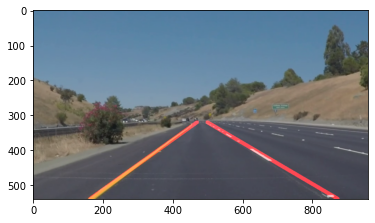

In [15]:

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image2)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
def HSV(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
def HLS(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    
def pipeline_challenge(image):
    
    
    img = np.copy(image)
    img1 = img[:,:,1]
    imgshape=img.shape
    #plt.subplot(2,3,1)
    #plt.imshow(img1, cmap = 'Reds')
    #convert image to grayscale
    hsv = HSV(img)
    #hsv = hsv[:,:,2]
    hls = HLS(img)
    # White Filter:
    thresh_low_w = np.asarray([0,0,200])
    thresh_high_w = np.asarray([180,25,255])
    hsv_w_mask = cv2.inRange(hsv,thresh_low_w, thresh_high_w)
    hsv_w = cv2.bitwise_and(hsv,hsv, mask= hsv_w_mask)

    # Yellow Filter
    thresh_low_y = np.array([15,75,75])
    thresh_high_y = np.array([35,255,255])
    hsv_y_mask = cv2.inRange(hsv,thresh_low_y, thresh_high_y)
    hsv_y = cv2.bitwise_and(hsv,hsv, mask= hsv_y_mask)
    
    combined = cv2.add(hsv_y, hsv_w)
    #plt.subplot(2,3,2)
    plt.imshow(combined)
    #hsv = weighted_img(hsv[:,:,0], hls[:,:,1], α=0.5, β=0.5, γ=0.)
    #plt.imshow(hsv)
    #Gaussian Blur to smoothen the image
    kernel_size = 5
    blurred = gaussian_blur(combined, kernel_size)
    #plt.subplot(2,3,3)
    #plt.imshow(blurred,cmap ='gray')
    #use canny edge detection to identify strong gradients and convert to binary image
    high_threshold = 150
    low_threshold = 50
    edges = canny(blurred, low_threshold, high_threshold)
    #plt.subplot(2,3,4)
    #plt.imshow(edges)
    #create Mask to identify region of interest
    vertices = np.array([[(0,imgshape[0]),(600,450),(720,450),(imgshape[1],imgshape[0])]],dtype = np.int32)
    masked = region_of_interest(edges, vertices)
    #plt.subplot(2,3,5)
    #plt.imshow(masked)
    #Perform Hough transform to identify lanes in region of interest
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 40
    max_line_gap = 50
    lines = hough_lines_challenge(masked, rho, theta, threshold, min_line_len, max_line_gap)
    print("lines", lines.shape)
    #combine lane lines with original image
    output = weighted_img(lines,img)
    
    #plot and return
    #plt.subplot(2,3,6)
    plt.imshow(output)
    return output

In [18]:
prev_slope_left =0
prev_intercept_left = 0
prev_slope_right =0
prev_intercept_right = 0
def process_image_challenge(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = pipeline_challenge(image)
    

    return result

t:   1%|▊                                                                    | 3/251 [00:00<00:12, 20.60it/s, now=None]

0.6083459024635496 3.461538461538453
-0.673728813559322 853.3150362191434
lines (720, 1280, 3)
Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

0.6083459024635496 3.461538461538453
-0.673728813559322 853.3150362191434
lines (720, 1280, 3)
0.5983606557377049 29.770491803278674
-0.7228425541465604 888.1276595744681
lines (720, 1280, 3)
0.6031746031746031 8.588235294117624
-0.6502732240437158 854.0120036409148


t:   3%|█▉                                                                   | 7/251 [00:00<00:12, 19.32it/s, now=None]

lines (720, 1280, 3)
0.6458333333333334 -26.087341772151888
-0.6493055555555556 846.791715571205
lines (720, 1280, 3)
0.5771290491118077 38.77272727272725
-0.7203603603603603 873.4054054054054
lines (720, 1280, 3)
0.5819397993311037 29.910768452982808
-0.6800202839756593 849.8368632336656
lines (720, 1280, 3)


t:   4%|██▍                                                                  | 9/251 [00:00<00:12, 18.82it/s, now=None]

0.625 2.6413043478260647
-0.6898231222763394 863.6206781914893
lines (720, 1280, 3)
0.6245300751879699 1.0
-0.6740506329113924 860.1118796908256
lines (720, 1280, 3)
0.6242424242424243 -4.468939393939394
-0.7267921146953404 893.3333333333334
lines (720, 1280, 3)
0.6210526315789474 -6.628024606971962
-0.7005488860841234 872.7017543859649
lines (720, 1280, 3)


t:   6%|████                                                                | 15/251 [00:00<00:13, 18.12it/s, now=None]

0.6220472440944882 3.4131578947367984
-0.6825396825396826 879.7777777777778
lines (720, 1280, 3)
0.601123595505618 22.75147928994079
-0.75 890.9108910891089
lines (720, 1280, 3)
0.5752212389380531 43.9473684210526
-0.7014476818764889 873.6358581788879
lines (720, 1280, 3)
0.6036036036036037 21.09009009009003
-0.7508601497672536 891.4654061698004
lines (720, 1280, 3)


t:   7%|████▉                                                               | 18/251 [00:00<00:12, 18.91it/s, now=None]

0.6014705882352941 19.425638179800245
-0.7269924952825433 873.4778249165133
lines (720, 1280, 3)
0.704225352112676 -55.08450704225345
-0.7539432176656151 908.4794952681389
lines (720, 1280, 3)
0.6 -11.491358024691323
-0.7274241065710261 885.6440677966102
lines (720, 1280, 3)
0.6475806451612903 -14.100000000000023
-0.7058324496288442 882.1428571428571
lines (720, 1280, 3)
0.6090976832407533 7.801652892561947
-0.7039305909746092 875.0345659163987


t:   8%|█████▋                                                              | 21/251 [00:01<00:11, 19.35it/s, now=None]

lines (720, 1280, 3)
0.6131815044858523 8.086956521739125
-0.7293507910529187 887.275
lines (720, 1280, 3)
0.5773809523809523 36.470467032967065
-0.7477477477477478 879.4369747899159
lines (720, 1280, 3)
0.5935044525929807 19.13043478260869
-0.748883635408458 883.056626506024
lines (720, 1280, 3)


t:  11%|███████▎                                                            | 27/251 [00:01<00:11, 20.04it/s, now=None]

0.6049382716049383 14.586206896551744
-0.752442996742671 907.7035830618893
lines (720, 1280, 3)
0.5882352941176471 34.78688524590166
-0.7548387096774194 906.028013029316
lines (720, 1280, 3)
0.5887745974955277 31.76923076923083
-0.7068965517241379 872.3806228373703
lines (720, 1280, 3)
0.6194690265486725 12.867866951480039
-0.7659574468085106 894.6852941176471
lines (720, 1280, 3)
0.6210106382978724

t:  12%|████████▏                                                           | 30/251 [00:01<00:10, 20.25it/s, now=None]

 8.824468085106389
-0.7291666666666666 900.3
lines (720, 1280, 3)
0.746268656716418 -95.08976545842216
-0.7 866.4426086956521
lines (720, 1280, 3)
0.6818181818181818 -45.90213903743313
-0.7162114098733817 874.3409090909091
lines (720, 1280, 3)
0.6533333333333333 -16.098805375808865
-0.7022900763358778 879.2555066079295
lines (720, 1280, 3)


t:  14%|█████████▊                                                          | 36/251 [00:01<00:10, 21.03it/s, now=None]

0.6208445642407907 12.509433962264154
-0.7083333333333334 879.6374312843577
lines (720, 1280, 3)
0.6946248196248196 -46.76875901875897
-0.7486263736263736 884.0875
lines (720, 1280, 3)
0.623877245508982 7.328488372093034
-0.6862745098039216 863.8235294117646
lines (720, 1280, 3)
0.6203703703703703 0.44689542483655487
-0.7481481481481481 869.6809392265193
lines (720, 1280, 3)
0.6008130081300813 28.470731707317043
-0.6756746227566683 858.7425742574258
lines (720, 1280, 3)


t:  16%|██████████▌                                                         | 39/251 [00:01<00:09, 21.30it/s, now=None]

0.6220434312958617 9.877388067012816
-0.72 889.8660231660232
lines (720, 1280, 3)
0.6268656716417911 -3.562830687830683
-0.7206751054852321 890.9842342342342
lines (720, 1280, 3)
0.6153846153846154 6.864197530864203
-0.6764705882352942 858.3636363636364
lines (720, 1280, 3)
0.6874322860238353 -41.44095341278441
-0.7 877.5267350501964
lines (720, 1280, 3)
0.6518358185024852 -16.65432098765433
-0.6984359726295211

t:  17%|███████████▍                                                        | 42/251 [00:02<00:09, 21.63it/s, now=None]

 875.1650055370985
lines (720, 1280, 3)
0.6350806451612903 -8.258064516129025
-0.7228915662650602 877.2529081844621
lines (720, 1280, 3)
0.6448598130841121 -12.349497443131696
-0.6741076980475065 864.6206896551724
lines (720, 1280, 3)
0.624 5.226728926326075
-0.65 849.3719678015882
lines (720, 1280, 3)
0.6070329260330193 8.33774834437088
-0.6513409961685823 848.3062273538947
lines (720, 1280, 3)


t:  19%|█████████████                                                       | 48/251 [00:02<00:09, 21.60it/s, now=None]

0.6 13.454545454545439
-0.6290540540540541 831.4556962025317
lines (720, 1280, 3)
0.6210552679913174 9.535353535353465
-0.6909090909090909 870.8
lines (720, 1280, 3)
0.5789473684210527 47.12500000000006
-0.6764705882352942 865.75
lines (720, 1280, 3)
0.5972697783384393 29.708680681406264
-0.7019607843137254 867.7272727272727
lines (720, 1280, 3)
0.6007246376811595 16.03333333333336
-0.7241379310344828 880.1228070175439


t:  20%|█████████████▊                                                      | 51/251 [00:02<00:09, 21.03it/s, now=None]

lines (720, 1280, 3)
0.6 27.399999999999977
-0.7271332961517011 884.8651685393259
lines (720, 1280, 3)
0.7313432835820896 -74.73333333333335
-0.6750788643533123 861.3485284768707
lines (720, 1280, 3)
0.6493506493506493 -43.351845522898174
-0.6962025316455697 869.8
lines (720, 1280, 3)
0.6421052631578947 -32.27621832358673
-0.6610169491525424 868.0526315789474


t:  23%|███████████████▍                                                    | 57/251 [00:02<00:09, 20.86it/s, now=None]

lines (720, 1280, 3)
0.6203405738803969 7.831858407079665
-0.7142857142857143 876.5524118738405
lines (720, 1280, 3)
0.6224489795918368 6.122448979591837
-0.7247706422018348 883.7027666545323
lines (720, 1280, 3)
0.6285714285714286 1.6578462954440738
-0.7115384615384616 885.7927786499215
lines (720, 1280, 3)
0.6302521008403361 1.1701680672268822
-0.7504325259515571 906.8560990358451
lines (720, 1280, 3)


t:  25%|████████████████▊                                                   | 62/251 [00:03<00:13, 14.45it/s, now=None]

0.6052631578947368 27.021276595744666
-0.7225268699276157 882.2396313364055
lines (720, 1280, 3)
0.59846757852077 22.58823529411768
-0.7222222222222222 880.6572769953052
lines (720, 1280, 3)
0.5952380952380952 29.075396825396865
-0.75 894.9166666666666
lines (720, 1280, 3)
0.6027397260273972 9.286048064085492
-0.723879920188645 875.2020202020202
lines (720, 1280, 3)


t:  25%|█████████████████▎                                                  | 64/251 [00:03<00:11, 15.59it/s, now=None]

0.6375930521091812 -18.076923076923094
-0.7003978582583475 866.9876360248973
lines (720, 1280, 3)
0.6986301369863014 -56.58904109589048
-0.75 909.2972972972973
lines (720, 1280, 3)
0.625 -18.55555555555557
-0.7009803921568627 878.9306930693069
lines (720, 1280, 3)
0.6491112574061882 -18.612244897959158
-0.7093023255813954 893.2332041343669
lines (720, 1280, 3)


t:  28%|██████████████████▉                                                 | 70/251 [00:03<00:10, 17.90it/s, now=None]

0.6185125735687533 8.047619047619037
-0.6933760683760684 872.0480769230769
lines (720, 1280, 3)
0.6280487804878049 -8.876046596286841
-0.7241379310344828 888.6896551724137
lines (720, 1280, 3)
0.598750405712431 25.666666666666686
-0.6734345091605141 860.6
lines (720, 1280, 3)
0.6 16.66590909090911
-0.6746031746031746 861.7278554166229
lines (720, 1280, 3)
0.5985074626865672 22.800000000000068
-0.7269736842105263 886.901098901099


t:  29%|████████████████████                                                | 74/251 [00:03<00:09, 18.81it/s, now=None]

lines (720, 1280, 3)
0.5978260869565217 25.954545454545382
-0.7264957264957265 882.5274725274726
lines (720, 1280, 3)
0.5808232931726908 35.188679245283026
-0.75 876.2942431294326
lines (720, 1280, 3)
0.5849056603773585 25.45454545454544
-0.702601216698133 872.6179140961472
lines (720, 1280, 3)


t:  30%|████████████████████▌                                               | 76/251 [00:04<00:09, 19.11it/s, now=None]

0.6134423897581792 7.611664295874846
-0.7241115609536661 886.8421052631579
lines (720, 1280, 3)
0.6176470588235294 5.464817572598633
-0.6785714285714286 870.9320193637622
lines (720, 1280, 3)
0.5861611876988335 28.63043478260863
-0.7539936102236422 918.5465201465202
lines (720, 1280, 3)
0.5970149253731343 20.39206744057492
-0.75 916.628510182208
lines (720, 1280, 3)


t:  33%|██████████████████████▏                                             | 82/251 [00:04<00:08, 19.66it/s, now=None]

0.5584795321637427 45.60903947537608
-0.7216494845360825 890.5064935064935
lines (720, 1280, 3)
0.5971698113207546 21.790540540540576
-0.6784906371748147 878.8923076923077
lines (720, 1280, 3)
0.5881374722838137 21.954545454545382
-0.7013227363042862 883.4563156400795
lines (720, 1280, 3)
0.5655637254901961 48.0
-0.7009803921568627 882.8461538461538
lines (720, 1280, 3)
0.5786616161616162 31.950000000000045
-0.78 923.1052631578948


t:  34%|███████████████████████                                             | 85/251 [00:04<00:08, 19.89it/s, now=None]

lines (720, 1280, 3)
0.5513513513513514 64.16585563665853
-0.7526881720430108 895.7727272727273
lines (720, 1280, 3)
0.55 65.44999999999996
-0.7263843648208469 896.5925901305147
lines (720, 1280, 3)
0.5588235294117647 48.78443328550935
-0.8091603053435115 941.551724137931
lines (720, 1280, 3)
0.5454545454545454 61.81818181818187


t:  35%|███████████████████████▊                                            | 88/251 [00:04<00:08, 19.90it/s, now=None]

-0.7701096186506098 900.54
lines (720, 1280, 3)
0.5538461538461539 38.36842105263156
-0.8048490257325599 911.3837600079075
lines (720, 1280, 3)
0.5851063829787234 30.288297872340422
-0.8357487922705314 951.3396656534953
lines (720, 1280, 3)
0.5565388397246804 54.66371681415933
-0.8083623693379791 952.0376984126984
lines (720, 1280, 3)


t:  37%|█████████████████████████▍                                          | 94/251 [00:04<00:07, 19.93it/s, now=None]

0.5579813320677107 56.16439909297051
-0.7727272727272727 921.2892561983471
lines (720, 1280, 3)
0.553639846743295 52.14190093708166
-0.7700515947467167 917.6194690265486
lines (720, 1280, 3)
0.5757575757575758 43.05649459418302
-0.7531380753138075 910.0
lines (720, 1280, 3)
0.5536227717078781 57.39189189189187
-0.7852100422570221 926.3407407407408
lines (720, 1280, 3)


t:  39%|██████████████████████████▎                                         | 97/251 [00:05<00:07, 19.93it/s, now=None]

0.5526186378165724 57.28846153846155
-0.8010416666666667 930.1005917159763
lines (720, 1280, 3)
0.5451329937747595 59.131578947368325
-0.7960400255482223 930.3865345181134
lines (720, 1280, 3)
0.5217391304347826 77.32203389830511
-0.8374491869918699 937.8571428571429
lines (720, 1280, 3)
0.5538461538461539 59.27692307692308
-0.8370884189611127 957.5571955719557
lines (720, 1280, 3)


t:  40%|██████████████████████████▉                                        | 101/251 [00:05<00:07, 19.47it/s, now=None]

0.5538461538461539 59.27692307692308
-0.8214285714285714 950.516129032258
lines (720, 1280, 3)
0.6714285714285714 -31.4571428571428
-0.8095238095238095 938.2187851518561
lines (720, 1280, 3)
0.5852941176470587 35.655882352941205
-0.8076923076923077 930.8099209833188
lines (720, 1280, 3)
0.4497288277012933 146.6136837713809
-0.8108228980322003 938.8837209302326
lines (720, 1280, 3)


t:  41%|███████████████████████████▊                                       | 104/251 [00:05<00:07, 19.80it/s, now=None]

0.5490196078431373 65.13725490196077
-0.807578539371685 935.6437246963562
lines (720, 1280, 3)
0.5573770491803278 56.618569813453945
-0.7863247863247863 920.483870967742
lines (720, 1280, 3)
0.47058823529411764 134.76470588235293
-0.74 894.2873913043478
lines (720, 1280, 3)
0.5147058823529411 85.75308349146113
-0.7558139534883721 910.7234042553191
lines (720, 1280, 3)
0.5112807463952502 102.42222222222227
-0.8178599527930763 916.7569124423962


t:  44%|█████████████████████████████▎                                     | 110/251 [00:05<00:07, 19.98it/s, now=None]

lines (720, 1280, 3)
0.5043834015195792 110.31414377556985
-0.7083333333333334 884.8543689320388
lines (720, 1280, 3)
0.5447703959351932 54.02693208430918
-0.7260216847372811 890.5320081549439
lines (720, 1280, 3)
0.5084745762711864 103.87288135593221
-0.80669434353918 920.8451536643026
lines (720, 1280, 3)


t:  45%|██████████████████████████████▏                                    | 113/251 [00:05<00:06, 20.16it/s, now=None]

0.6111742424242423 8.962264150943383
-0.7380952380952381 898.2217831813576
lines (720, 1280, 3)
0.7377450980392157 -90.5
-0.7272727272727273 880.3333333333333
lines (720, 1280, 3)
0.7017543859649122 -56.28070175438597
-0.75 884.5
lines (720, 1280, 3)
0.6981132075471698 -52.226415094339586
-0.6755585995872767 847.2354479470575
lines (720, 1280, 3)


t:  46%|██████████████████████████████▉                                    | 116/251 [00:06<00:06, 20.13it/s, now=None]

0.6153846153846154 6.0
-0.7251184834123223 868.1535087719299
lines (720, 1280, 3)
0.5777777777777777 34.911111111111154
-0.6855742296918768 851.952380952381
lines (720, 1280, 3)
0.5853723404255319 28.765957446808557
-0.6988725906170445 868.6709302325581
lines (720, 1280, 3)
0.5925925925925926 30.148148148148152
-0.6493789217569471 844.0949432404541
lines (720, 1280, 3)


t:  49%|████████████████████████████████▌                                  | 122/251 [00:06<00:06, 20.23it/s, now=None]

0.5757575757575758 45.07226107226103
-0.6748466257668712 861.320652173913
lines (720, 1280, 3)
0.5764705882352941 38.85294117647061
-0.6634504370773544 845.338689217759
lines (720, 1280, 3)
0.5961538461538461 23.4375
-0.701528384279476 859.2479358912093
lines (720, 1280, 3)
0.5985401459854015 31.277372262773724
-0.6491614494796634 796.777731092437
lines (720, 1280, 3)
0.576095947063689 46.42892052698687
-0.6759259259259259 854.475


t:  50%|█████████████████████████████████▎                                 | 125/251 [00:06<00:06, 20.26it/s, now=None]

lines (720, 1280, 3)
0.6194029850746269 3.5
-0.6395326192794548 831.875
lines (720, 1280, 3)
0.5977011494252874 27.399999999999977
-0.6739130434782609 840.191056910569
lines (720, 1280, 3)
0.7290357529794149 -73.90303358613215
-0.6721311475409836 835.2696041822255
lines (720, 1280, 3)


t:  51%|██████████████████████████████████▏                                | 128/251 [00:06<00:06, 20.28it/s, now=None]

0.72 -64.43999999999994
-0.6649025465926874 849.9497032177444
lines (720, 1280, 3)
0.6728260869565217 -30.24999999999997
-0.6507936507936508 834.952380952381
lines (720, 1280, 3)
0.6458333333333334 -17.53125
-0.6649455606689865 848.5025650592295
lines (720, 1280, 3)
0.6377995642701525 -10.40740740740739
-0.6236447220053778 817.4901960784314
lines (720, 1280, 3)
0.6197183098591549 13.131578947368382
-0.6702127659574468 844.3953488372092


t:  53%|███████████████████████████████████▊                               | 134/251 [00:06<00:05, 20.32it/s, now=None]

lines (720, 1280, 3)
0.6163342830009497 11.37400530503976
-0.6272189349112426 821.75
lines (720, 1280, 3)
0.6266666666666667 -4.068534289556226
-0.628099173553719 817.701524544781
lines (720, 1280, 3)
0.6012269938650306 26.5
-0.6714285714285714 818.952380952381
lines (720, 1280, 3)


t:  55%|████████████████████████████████████▌                              | 137/251 [00:07<00:05, 20.16it/s, now=None]

0.6 27.399999999999977
-0.6666666666666666 827.9634146341464
lines (720, 1280, 3)
0.631578947368421 -3.591142490372249
-0.626453488372093 828.2093023255813
lines (720, 1280, 3)
0.6116780045351474 19.0
-0.6420947689420596 821.4054054054054
lines (720, 1280, 3)
0.6376811594202898 -4.357057772483614
-0.6798611111111111 843.5831207482993
lines (720, 1280, 3)


t:  57%|█████████████████████████████████████▉                             | 142/251 [00:07<00:05, 19.64it/s, now=None]

0.6370659107016301 -12.493975903614455
-0.623767895808422 828.3650793650794
lines (720, 1280, 3)
0.6178750569995439 11.58139534883719
-0.6453571428571429 834.6903914590747
lines (720, 1280, 3)
0.6218487394957983 12.899017234012263
-0.6245915032679739 825.1203066332916
lines (720, 1280, 3)
0.6470588235294118 -7.017174753112926
-0.6461538461538462 836.2199635922331
lines (720, 1280, 3)


t:  58%|██████████████████████████████████████▉                            | 146/251 [00:07<00:05, 19.44it/s, now=None]

0.6014244426094137 10.416184971098232
-0.6437345715293288 822.9368421052632
lines (720, 1280, 3)
0.6274509803921569 2.543424699722806
-0.5770979020979021 795.2959080575903
lines (720, 1280, 3)
0.5993630573248407 -6.084272508547485
-0.600395256916996 806.5691699604743
lines (720, 1280, 3)
0.6666666666666666 -25.349514563106823
-0.6007326007326007 813.2003612523415
lines (720, 1280, 3)


t:  60%|████████████████████████████████████████                           | 150/251 [00:07<00:05, 19.55it/s, now=None]

0.6227766227766227 11.56465517241378
-0.6021798365122616 817.5590062111801
lines (720, 1280, 3)
0.6129032258064516 21.580645161290363
-0.5789473684210527 803.7485714285715
lines (720, 1280, 3)
0.6129032258064516 21.580645161290363
-0.6024868705591597 810.2270421106037
lines (720, 1280, 3)
0.6129032258064516 21.580645161290363
-0.5766170368562362 802.5849056603773
lines (720, 1280, 3)
0.6129032258064516 21.580645161290363
-0.5990196078431372

t:  61%|████████████████████████████████████████▊                          | 153/251 [00:07<00:04, 19.97it/s, now=None]

 814.085991284027
lines (720, 1280, 3)
0.4418604651162791 169.1395348837209
-0.6153846153846154 816.126582278481
lines (720, 1280, 3)
0.4888888888888889 131.8888888888889
-0.625 824.0016375545852
lines (720, 1280, 3)
0.5294117647058824 55.50485436893206
-0.6125 816.8097902097902
lines (720, 1280, 3)


t:  62%|█████████████████████████████████████████▋                         | 156/251 [00:08<00:04, 20.08it/s, now=None]

0.696969696969697 -48.999278499278546
-0.6018867924528302 816.4063982291557
lines (720, 1280, 3)
0.5865384615384616 45.74358974358972
-0.6415094339622641 828.8461538461538
lines (720, 1280, 3)
0.5076923076923077 99.8390420899855
-0.5769230769230769 804.1988838153222
lines (720, 1280, 3)
0.6909090909090909 -43.9818181818182
-0.5853658536585366 815.0041606886657
lines (720, 1280, 3)
0.7371373836891078 -80.61029009304869
-0.623422159887798 819.8046558704453


t:  65%|███████████████████████████████████████████▏                       | 162/251 [00:08<00:04, 19.96it/s, now=None]

lines (720, 1280, 3)
0.6944444444444444 -48.63888888888886
-0.578125 794.1544635313996
lines (720, 1280, 3)
0.75 -93.68993506493507
-0.6194791002640925 807.2770533573141
lines (720, 1280, 3)
0.6956521739130435 -45.60869565217388
-0.5798319327731093 809.9754583651643
lines (720, 1280, 3)


t:  65%|███████████████████████████████████████████▊                       | 164/251 [00:08<00:04, 18.86it/s, now=None]

0.6607238247863247 -20.745072387929497
-0.6153846153846154 817.1639344262295
lines (720, 1280, 3)
0.6485655737704918 -12.127049180327845
-0.6007905138339921 813.4262626262627
lines (720, 1280, 3)
0.6959459459459459 -49.84655049786625
-0.5882352941176471 805.2905882352941
lines (720, 1280, 3)
0.680952380952381 -35.792857142857116
-0.6019417475728155 810.1034482758621
lines (720, 1280, 3)


t:  68%|█████████████████████████████████████████████▍                     | 170/251 [00:08<00:04, 18.07it/s, now=None]

0.6258503401360545 -6.550000000000068
-0.6002544529262086 823.5897435897436
lines (720, 1280, 3)
0.6026798861293805 18.875
-0.6 815.8644067796611
lines (720, 1280, 3)
0.6349206349206349 -0.9841092727972409
-0.6220980996404726 824.4547194719472
lines (720, 1280, 3)
0.65 -12.836065573770497
-0.616822429906542 830.0970270071382
lines (720, 1280, 3)


t:  69%|██████████████████████████████████████████████▏                    | 173/251 [00:08<00:04, 18.73it/s, now=None]

0.6415094339622641 -1.567200827087106
-0.6210211357270181 845.375
lines (720, 1280, 3)
0.6748493975903614 -24.879518072289102
-0.621253305906553 835.8910891089108
lines (720, 1280, 3)
0.6288659793814433 0.20618556701035118
-0.6254248553603529 837.9800102951269
lines (720, 1280, 3)
0.6 22.73333333333332
-0.6071428571428571 837.5121951219512
lines (720, 1280, 3)
0.625

t:  70%|██████████████████████████████████████████████▉                    | 176/251 [00:09<00:03, 19.37it/s, now=None]

 -0.37434210526316747
-0.6494076821826014 852.6849611063094
lines (720, 1280, 3)
0.6444444444444445 -11.111111111111143
-0.6447719688542826 844.4557721139431
lines (720, 1280, 3)
0.633953488372093 -7.04444444444448
-0.7478991596638656 897.525313010343
lines (720, 1280, 3)
0.6153846153846154 4.695652173913004
-0.6994047619047619 880.1175595238095
lines (720, 1280, 3)
0.6104336043360434 15.262987012987054
-0.6746031746031746 852.685


t:  73%|████████████████████████████████████████████████▌                  | 182/251 [00:09<00:03, 19.62it/s, now=None]

lines (720, 1280, 3)
0.6026490066225165 22.535714285714334
-0.6686746987951807 856.7858129766773
lines (720, 1280, 3)
0.6 21.102439024390293
-0.6987951807228916 877.4221190984032
lines (720, 1280, 3)
0.6 25.600000000000023
-0.75 900.0
lines (720, 1280, 3)


t:  73%|█████████████████████████████████████████████████                  | 184/251 [00:09<00:03, 19.58it/s, now=None]

0.6753246753246753 -51.070239619535414
-0.6760048261820375 861.4691521961184
lines (720, 1280, 3)
0.6796296296296296 -64.4626490897677
-0.6748466257668712 861.159509202454
lines (720, 1280, 3)
0.6 17.22972972972974
-0.6875 870.6111111111111
lines (720, 1280, 3)
0.6229508196721312 4.3821721311475414
-0.7128403831665052 876.0697674418604
lines (720, 1280, 3)


t:  76%|██████████████████████████████████████████████████▋                | 190/251 [00:09<00:03, 20.29it/s, now=None]

0.6041666666666666 -0.7708333333333144
-0.6676570458404074 864.9032258064516
lines (720, 1280, 3)
0.6257436934792956 -11.311688311688272
-0.7255237687569855 898.2964824120603
lines (720, 1280, 3)
0.6285106382978723 -9.639999999999986
-0.7708333333333334 904.7926267281106
lines (720, 1280, 3)
0.5789473684210527 36.22631578947366
-0.6914978678038379 868.1714751046999
lines (720, 1280, 3)
0.5959520239880061 28.9375
-0.7514260962281754 914.3676729308277


t:  77%|███████████████████████████████████████████████████▌               | 193/251 [00:09<00:02, 20.22it/s, now=None]

lines (720, 1280, 3)
0.5965673702899981 28.348293549023452
-0.7057289947858227 878.1995546420006
lines (720, 1280, 3)
0.591099090238505 26.60240963855415
-0.7408523908523909 897.581081081081
lines (720, 1280, 3)
0.6266233766233766 0.07597402597403402
-0.7265625 890.3360541044776
lines (720, 1280, 3)
0.6498015873015873 -18.734126984127016
-0.7007874015748031 887.176807444524


t:  78%|████████████████████████████████████████████████████▎              | 196/251 [00:10<00:02, 20.45it/s, now=None]

lines (720, 1280, 3)
0.5641025641025641 46.74358974358972
-0.702591020772839 880.5986394557823
lines (720, 1280, 3)
0.6075565140985701 7.30864197530866
-0.7290836653386454 889.8703061768674
lines (720, 1280, 3)
0.5972222222222222 19.400560224089645
-0.7279935762320586 890.9268292682927
lines (720, 1280, 3)
0.5940917578020806 22.136986301369916
-0.7299270072992701 892.6216216216217


t:  80%|█████████████████████████████████████████████████████▉             | 202/251 [00:10<00:02, 20.44it/s, now=None]

lines (720, 1280, 3)
0.5979381443298969 22.108442004118046
-0.7262489762489763 891.1855188521856
lines (720, 1280, 3)
0.5818181818181818 27.36986301369859
-0.7752808988764045 908.4594594594595
lines (720, 1280, 3)
0.5714285714285714 45.4102370689655
-0.7531645569620253 900.1730769230769
lines (720, 1280, 3)


t:  82%|██████████████████████████████████████████████████████▋            | 205/251 [00:10<00:02, 20.41it/s, now=None]

0.5871212121212122 32.09090909090901
-0.7293374316939891 883.6170212765958
lines (720, 1280, 3)
0.574468085106383 41.34586288416074
-0.7516129032258064 911.5555555555555
lines (720, 1280, 3)
0.5726183518410286 36.80785195434106
-0.7789178213091257 927.6697674418605
lines (720, 1280, 3)
0.6265060240963856 -0.6024096385542066
-0.7777777777777778 920.9569892473119
lines (720, 1280, 3)
0.7076923076923077

t:  83%|███████████████████████████████████████████████████████▌           | 208/251 [00:10<00:02, 20.26it/s, now=None]

 -59.53846153846155
-0.7299270072992701 892.9448818897638
lines (720, 1280, 3)
0.5813953488372093 21.961538461538453
-0.8093555443378765 945.9936059229345
lines (720, 1280, 3)
0.6131496062992126 15.225590551181085
-0.7511904761904762 909.9624304267161
lines (720, 1280, 3)
0.6379416851989128 -25.38422342621257
-0.8020833333333334 932.0571428571429
lines (720, 1280, 3)
0.6280184443635481

t:  85%|█████████████████████████████████████████████████████████          | 214/251 [00:10<00:01, 20.45it/s, now=None]

 -2.975609756097583
-0.7825619771279453 923.2380952380952
lines (720, 1280, 3)
0.6153846153846154 5.5
-0.7766990291262136 923.2476190476191
lines (720, 1280, 3)
0.5782193648938243 26.323741007194258
-0.7789232531500573 924.2670250896058
lines (720, 1280, 3)
0.5554945054945055 48.524675324675314
-0.7804878048780488 920.3898305084746
lines (720, 1280, 3)


t:  86%|█████████████████████████████████████████████████████████▉         | 217/251 [00:11<00:01, 20.62it/s, now=None]

0.5671641791044776 51.66666666666663
-0.7743367935409458 916.332
lines (720, 1280, 3)
0.5591397849462365 48.673784643343936
-0.7546127167630058 908.917372881356
lines (720, 1280, 3)
0.5591827670441927 52.38596491228071
-0.8085464491093552 953.1824817518248
lines (720, 1280, 3)
0.5714285714285714 40.71428571428572
-0.8022044573643411 931.4791666666667
lines (720, 1280, 3)
0.55

t:  88%|██████████████████████████████████████████████████████████▋        | 220/251 [00:11<00:01, 20.53it/s, now=None]

 57.9264150943396
-0.7839506172839507 933.5855590348131
lines (720, 1280, 3)
0.5833333333333334 35.74999999999994
-0.7827517162471396 923.5171102661598
lines (720, 1280, 3)
0.5645161290322581 41.30927835051551
-0.7850467289719626 933.0763457556936
lines (720, 1280, 3)
0.5753424657534246 42.85060739209101
-0.7831325301204819 921.9277108433735
lines (720, 1280, 3)
0.555005500550055 58.0
-0.7579617834394905 910.7680779318097

t:  90%|████████████████████████████████████████████████████████████▎      | 226/251 [00:11<00:01, 20.55it/s, now=None]


lines (720, 1280, 3)
0.5631912817176317 46.39622641509436
-0.79 930.9419191919192
lines (720, 1280, 3)
0.5333333333333333 67.32558139534888
-0.7557251908396947 910.5
lines (720, 1280, 3)
0.53125 78.64739884393066
-0.7836617405582923 920.7922077922078
lines (720, 1280, 3)


t:  91%|█████████████████████████████████████████████████████████████▏     | 229/251 [00:11<00:01, 20.65it/s, now=None]

0.5528455284552846 64.51785714285711
-0.756578947368421 909.0263157894738
lines (720, 1280, 3)
0.5517241379310345 65.06688005390839
-0.8367950925527335 948.7272727272727
lines (720, 1280, 3)
0.6764755623203111 -33.003636056147485
-0.7605144247480013 924.3158263305322
lines (720, 1280, 3)
0.6461538461538462 -11.41469317199659
-0.7837837837837838 935.3904761904762
lines (720, 1280, 3)
0.6355263157894737 -1.8249999999999886
-0.8032786885245902 912.9583622484386


t:  92%|█████████████████████████████████████████████████████████████▉     | 232/251 [00:11<00:00, 20.68it/s, now=None]

lines (720, 1280, 3)
0.6015625 19.51026526162792
-0.8078291814946619 933.8780487804878
lines (720, 1280, 3)
0.6015411893071467 25.92682760501907
-0.7605325244354567 909.0
lines (720, 1280, 3)
0.5813953488372093 31.860465116279045
-0.7538461538461538 905.063725490196
lines (720, 1280, 3)
0.5752212389380531 48.333333333333314
-0.75 904.2838248707814


t:  95%|███████████████████████████████████████████████████████████████▌   | 238/251 [00:12<00:00, 20.77it/s, now=None]

lines (720, 1280, 3)
0.581081081081081 32.743243243243285
-0.7753623188405797 904.0
lines (720, 1280, 3)
0.5675675675675675 50.91891891891896
-0.7564102564102564 904.013986013986
lines (720, 1280, 3)
0.5932203389830508 21.19999999999999
-0.767868316268487 905.8964767616192
lines (720, 1280, 3)


t:  96%|████████████████████████████████████████████████████████████████▎  | 241/251 [00:12<00:00, 20.81it/s, now=None]

0.578125 31.324979707792238
-0.7866666666666666 931.7142857142858
lines (720, 1280, 3)
0.6025641025641025 9.336894586894601
-0.7785234899328859 908.4485294117646
lines (720, 1280, 3)
0.6098901098901099 7.53846153846149
-0.8170731707317073 944.6209349593496
lines (720, 1280, 3)
0.6118811881188119 15.700000000000017
-0.8072283445905912 911.2553191489362
lines (720, 1280, 3)
0.5971014492753624 21.80000000000001
-0.7871939736346516 914.7777777777778
lines (720, 1280, 3)


t:  98%|█████████████████████████████████████████████████████████████████▉ | 247/251 [00:12<00:00, 21.23it/s, now=None]

0.6219512195121951 1.5753387533875127
-0.7814698398443347 927.1940298507462
lines (720, 1280, 3)
0.5885131305497827 31.797468354430407
-0.7543859649122807 906.4371035940803
lines (720, 1280, 3)
0.5979381443298969 26.154639175257728
-0.8022988505747126 931.7770700636943
lines (720, 1280, 3)
0.6056547619047619 19.22033898305085
-0.7810332456350155 903.4864864864865
lines (720, 1280, 3)


t: 100%|██████████████████████████████████████████████████████████████████▋| 250/251 [00:12<00:00, 20.78it/s, now=None]

0.5805912914398812 30.186813186813197
-0.7692307692307693 907.6429765886288
lines (720, 1280, 3)
0.5555555555555556 52.690789473684276
-0.7553216753022453 911.7567567567568
lines (720, 1280, 3)
0.5729166666666666 49.37500000000006
-0.7201236263736264 895.1940298507463
lines (720, 1280, 3)
0.618421052631579 7.78947368421052
-0.7511061946902655 879.4137931034483
lines (720, 1280, 3)
0.6458333333333334 -13.352033132530124
-0.7369652814522365

 894.0227272727273
lines (720, 1280, 3)
Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 13.2 s


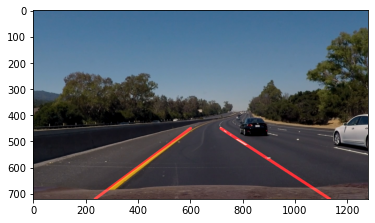

In [19]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,3)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_challenge)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))